**Import Library**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import (StandardScaler, 
                                   LabelEncoder)
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             f1_score,
                             roc_auc_score,
                             roc_curve, 
                             auc, 
                             classification_report, 
                             confusion_matrix)
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, 
                                     Input, 
                                     BatchNormalization, 
                                     Dropout)
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

**Data Understanding**

Data Load

In [3]:
obesity= pd.read_csv('data/ObesityDataSet_raw_and_data_sinthetic.csv')
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


**Exploratory Data Analysis**

Data Details

In [7]:
obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

Data Descriptive Statistics

In [6]:
print("\nDescriptive statistics:")
print(obesity.describe())


Descriptive statistics:
               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000     1.0

**Data Quality Assessment**

Missing Values Analysis

In [5]:
# Analisis Missing Values
print("Missing Values Analysis:")
print(obesity.isnull().sum())
print("\nDataset Shape:", obesity.shape)

# Analisis tipe data
print("\nData Types:")
print(obesity.dtypes)

Missing Values Analysis:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

Dataset Shape: (2111, 17)

Data Types:
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP             

Duplicate Analysis & Target Variable Distribution

In [9]:
# Cek duplikasi
print(f"Duplicate rows: {obesity.duplicated().sum()}")

# Analisis distribusi target variable
print("\nTarget Variable Distribution:")
print(obesity['NObeyesdad'].value_counts())
print("\nTarget Variable Percentages:")
print(obesity['NObeyesdad'].value_counts(normalize=True) * 100)

Duplicate rows: 24

Target Variable Distribution:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

Target Variable Percentages:
NObeyesdad
Obesity_Type_I         16.627191
Obesity_Type_III       15.348176
Obesity_Type_II        14.069162
Overweight_Level_I     13.737565
Overweight_Level_II    13.737565
Normal_Weight          13.595452
Insufficient_Weight    12.884889
Name: proportion, dtype: float64


**Variables Analysis for Statistical Analysis**

Numerical vs Categorical Variables

In [10]:
# Analisis tipe variabel untuk statistika
numerical_cols = obesity.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = obesity.select_dtypes(include=['object']).columns

print(f"Numerical variables ({len(numerical_cols)}):")
print(list(numerical_cols))

print(f"\nCategorical variables ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_count = obesity[col].nunique()
    print(f"- {col}: {unique_count} unique values")
    print(f"  Values: {list(obesity[col].unique())}")
    print()

Numerical variables (8):
['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

Categorical variables (9):
- Gender: 2 unique values
  Values: ['Female', 'Male']

- family_history_with_overweight: 2 unique values
  Values: ['yes', 'no']

- FAVC: 2 unique values
  Values: ['no', 'yes']

- CAEC: 4 unique values
  Values: ['Sometimes', 'Frequently', 'Always', 'no']

- SMOKE: 2 unique values
  Values: ['no', 'yes']

- SCC: 2 unique values
  Values: ['no', 'yes']

- CALC: 4 unique values
  Values: ['no', 'Sometimes', 'Frequently', 'Always']

- MTRANS: 5 unique values
  Values: ['Public_Transportation', 'Walking', 'Automobile', 'Motorbike', 'Bike']

- NObeyesdad: 7 unique values
  Values: ['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II', 'Obesity_Type_III']



Statistical Summary for Age:
count    2111.000000
mean       24.312600
std         6.345968
min        14.000000
25%        19.947192
50%        22.777890
75%        26.000000
max        61.000000
Name: Age, dtype: float64



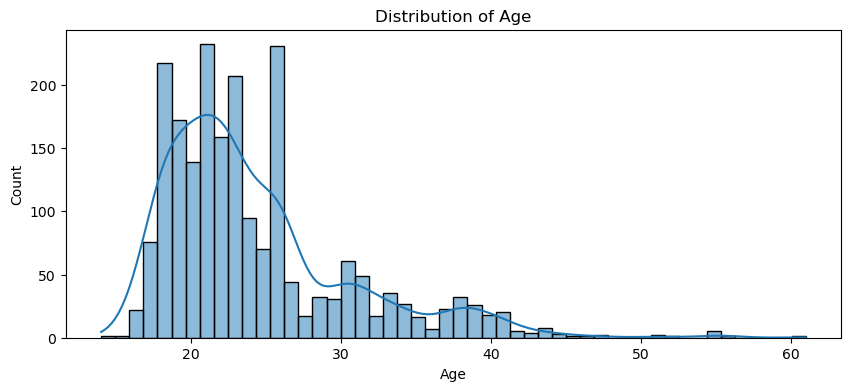

Statistical Summary for Height:
count    2111.000000
mean        1.701677
std         0.093305
min         1.450000
25%         1.630000
50%         1.700499
75%         1.768464
max         1.980000
Name: Height, dtype: float64



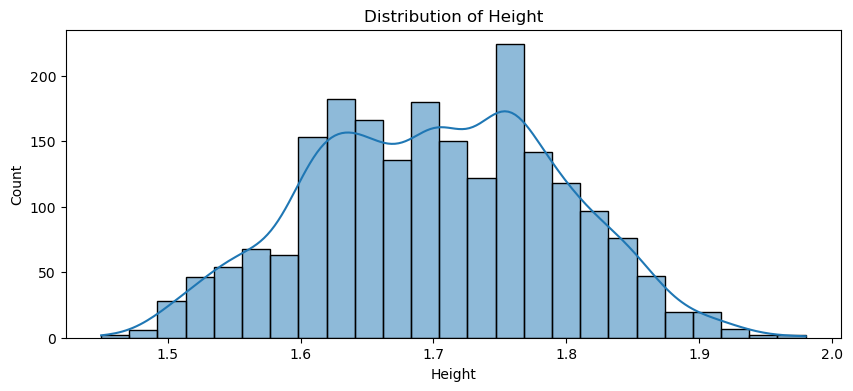

Statistical Summary for Weight:
count    2111.000000
mean       86.586058
std        26.191172
min        39.000000
25%        65.473343
50%        83.000000
75%       107.430682
max       173.000000
Name: Weight, dtype: float64



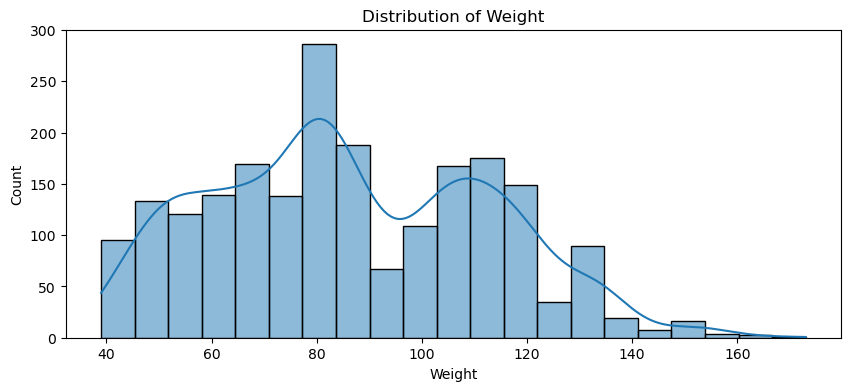

Statistical Summary for FCVC:
count    2111.000000
mean        2.419043
std         0.533927
min         1.000000
25%         2.000000
50%         2.385502
75%         3.000000
max         3.000000
Name: FCVC, dtype: float64



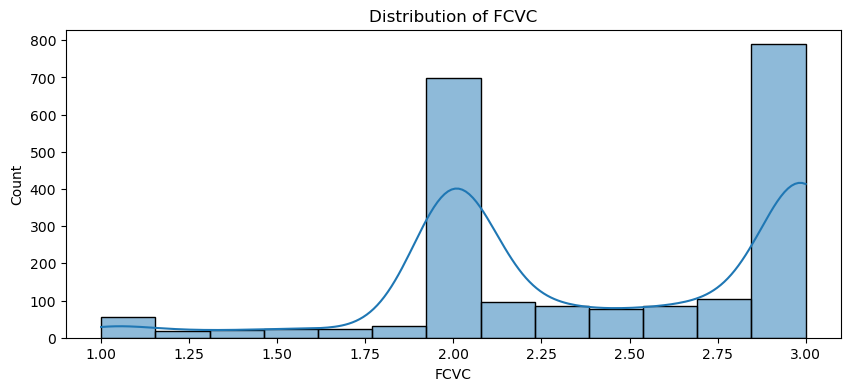

Statistical Summary for NCP:
count    2111.000000
mean        2.685628
std         0.778039
min         1.000000
25%         2.658738
50%         3.000000
75%         3.000000
max         4.000000
Name: NCP, dtype: float64



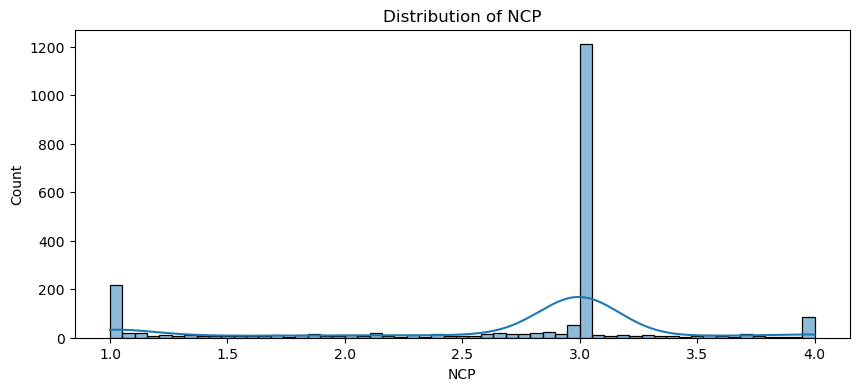

Statistical Summary for CH2O:
count    2111.000000
mean        2.008011
std         0.612953
min         1.000000
25%         1.584812
50%         2.000000
75%         2.477420
max         3.000000
Name: CH2O, dtype: float64



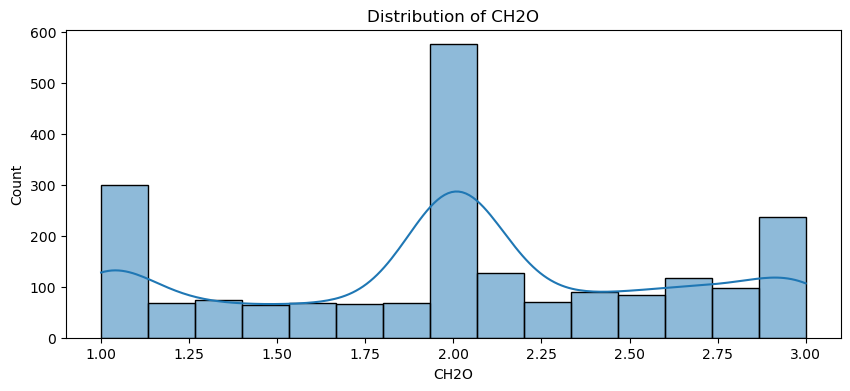

Statistical Summary for FAF:
count    2111.000000
mean        1.010298
std         0.850592
min         0.000000
25%         0.124505
50%         1.000000
75%         1.666678
max         3.000000
Name: FAF, dtype: float64



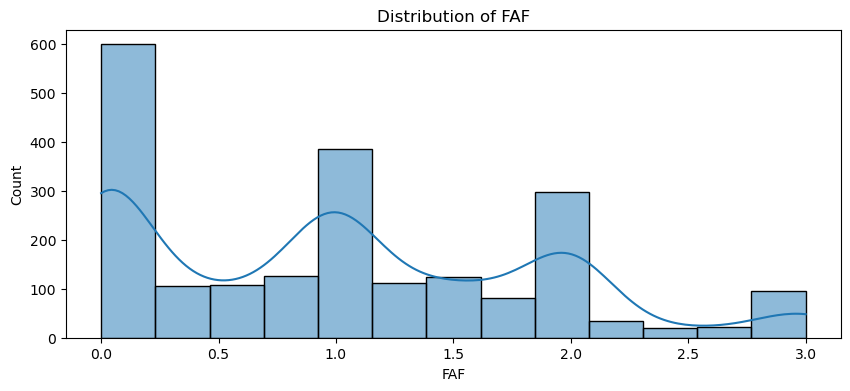

Statistical Summary for TUE:
count    2111.000000
mean        0.657866
std         0.608927
min         0.000000
25%         0.000000
50%         0.625350
75%         1.000000
max         2.000000
Name: TUE, dtype: float64



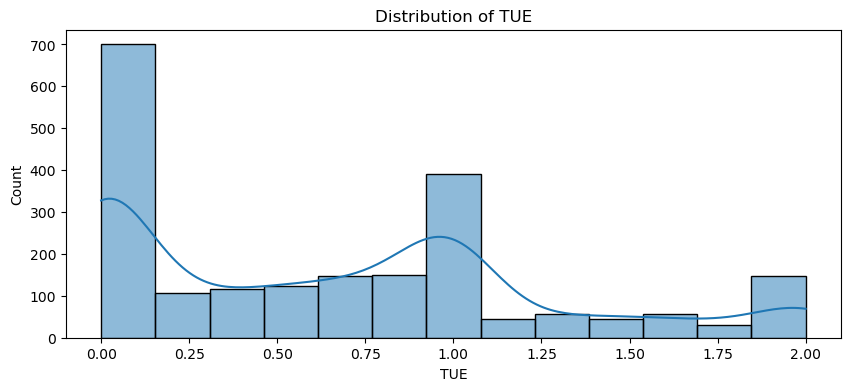

In [11]:
#Analisis numerical variables
for col in numerical_cols:
    print(f"Statistical Summary for {col}:")
    print(obesity[col].describe())
    print() 
    plt.figure(figsize=(10, 4))
    sns.histplot(obesity[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


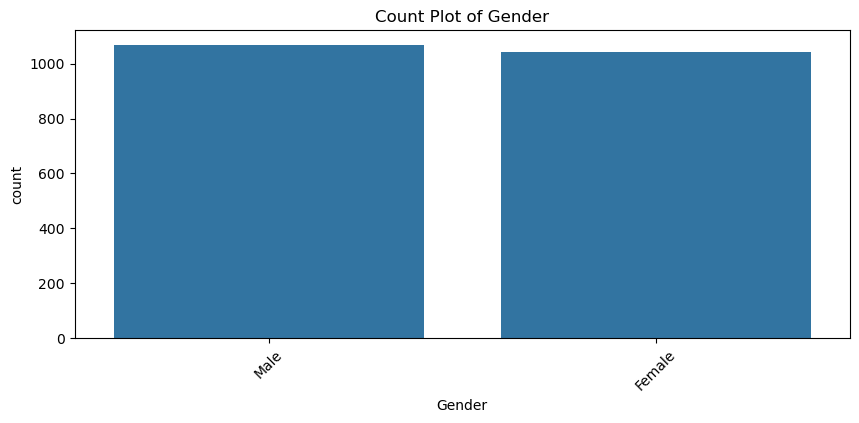

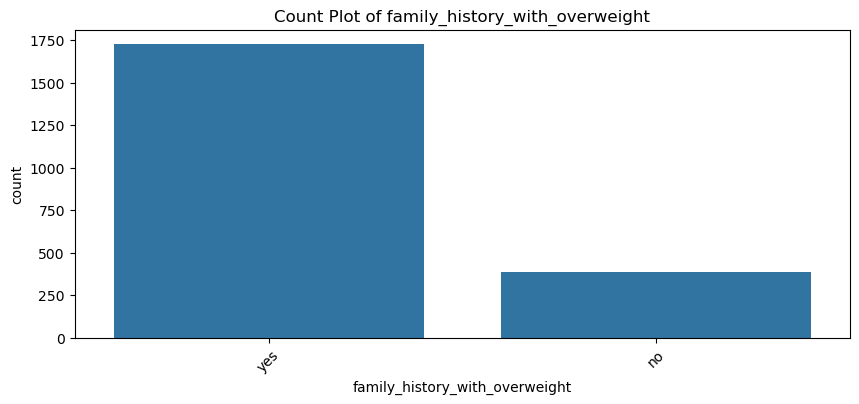

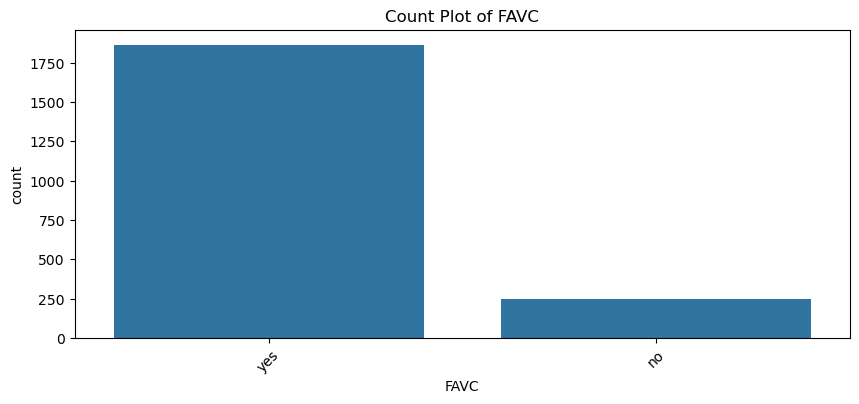

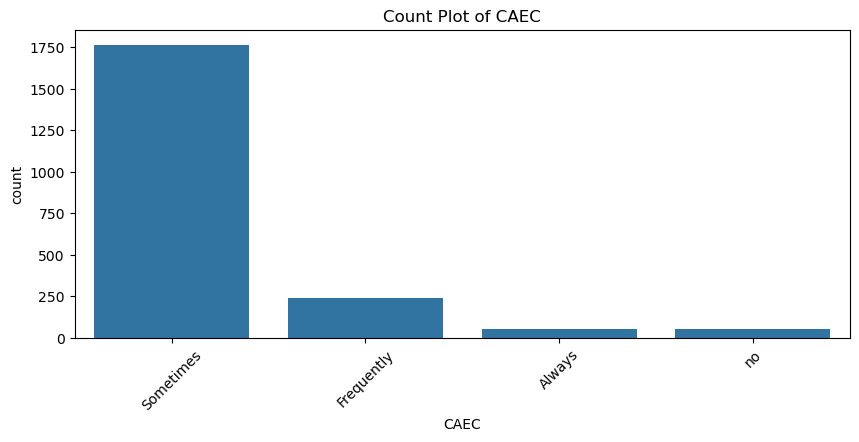

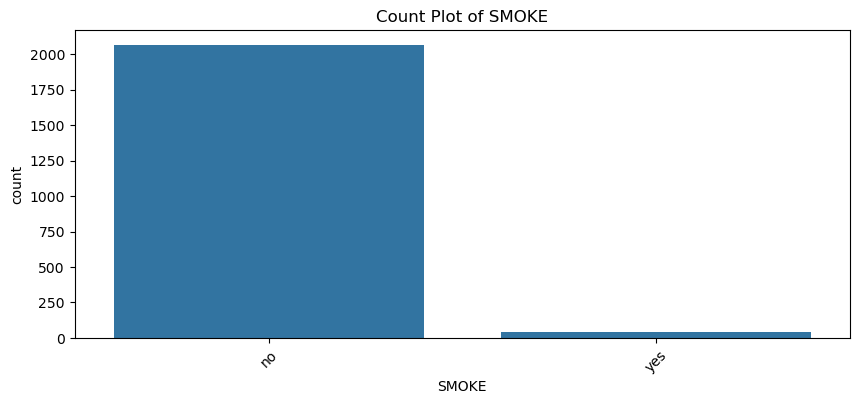

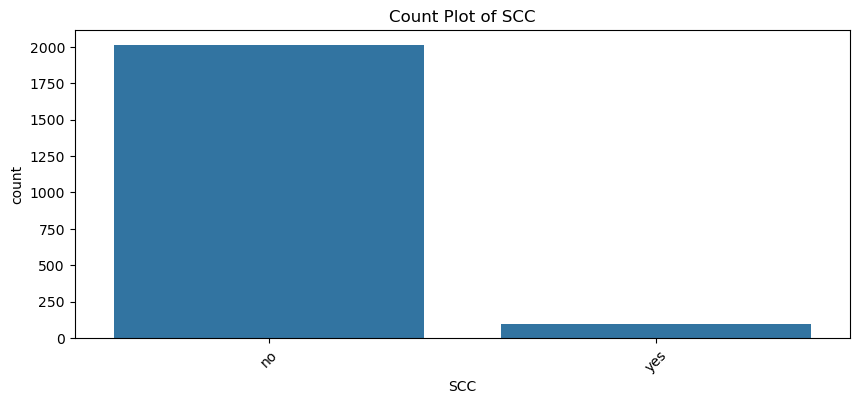

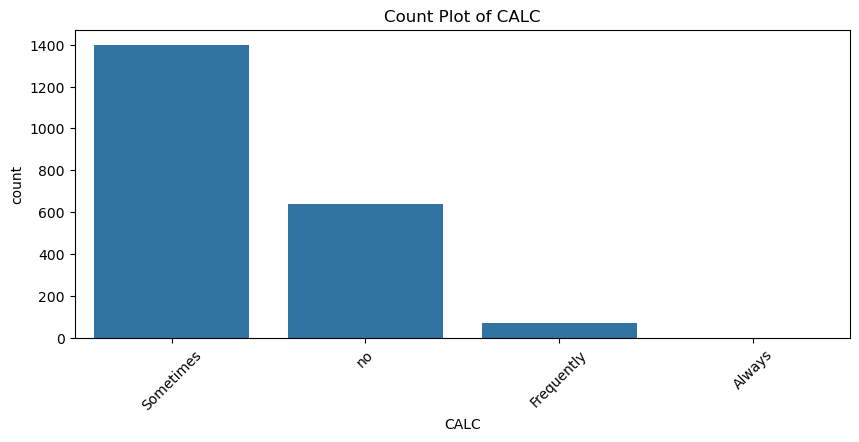

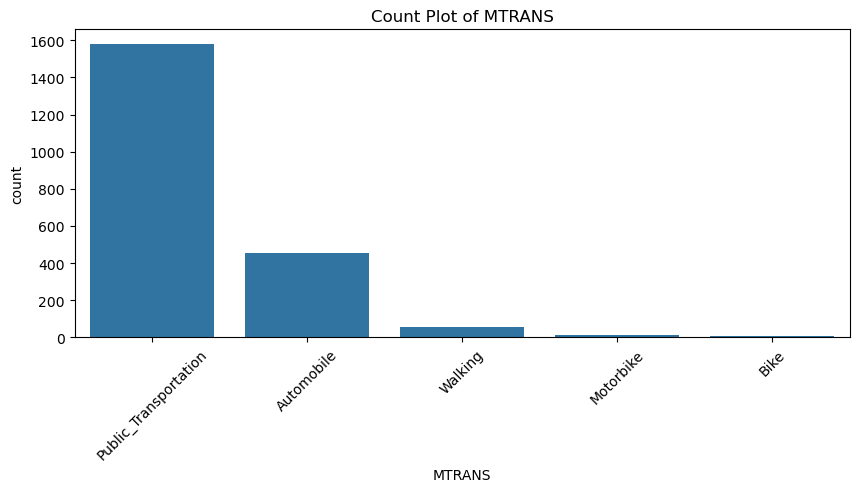

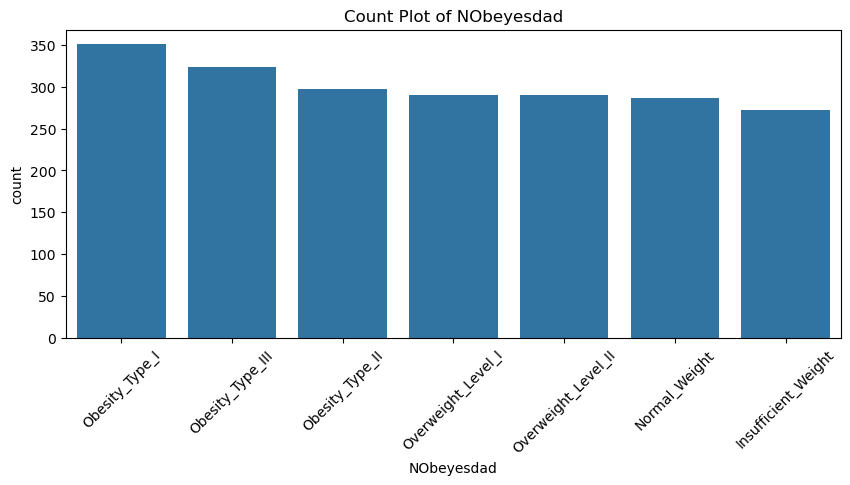

In [12]:
#Analisis plot categorical variables
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=obesity, x=col, order=obesity[col].value_counts().index)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.show()

**Data Quality Assessment Function**

In [13]:
def data_quality_check(df):
    """
    Fungsi untuk mengecek kualitas data dan memberikan rekomendasi
    """
    print("=== DATA QUALITY ASSESSMENT ===\n")
    
    # 1. Missing Values
    missing_vals = df.isnull().sum()
    print("1. MISSING VALUES:")
    if missing_vals.sum() == 0:
        print("✓ No missing values found")
    else:
        print(missing_vals[missing_vals > 0])
    
    # 2. Data Types
    print(f"\n2. DATA TYPES:")
    print(f"✓ Numerical variables: {len(df.select_dtypes(include=['float64', 'int64']).columns)}")
    print(f"✓ Categorical variables: {len(df.select_dtypes(include=['object']).columns)}")
    
    # 3. Duplicates
    duplicates = df.duplicated().sum()
    print(f"\n3. DUPLICATE RECORDS:")
    if duplicates == 0:
        print("✓ No duplicate records found")
    else:
        print(f"⚠ Found {duplicates} duplicate records")
    
    # 4. Sample Size
    print(f"\n4. SAMPLE SIZE:")
    print(f"✓ Total records: {len(df)}")
    print(f"✓ Features: {len(df.columns)-1}")
    
    # 5. Class Distribution
    target_col = 'NObeyesdad'
    if target_col in df.columns:
        print(f"\n5. TARGET VARIABLE DISTRIBUTION:")
        class_counts = df[target_col].value_counts()
        min_class = class_counts.min()
        max_class = class_counts.max()
        balance_ratio = min_class / max_class
        
        print(class_counts)
        print(f"\nBalance ratio: {balance_ratio:.2f}")
        if balance_ratio < 0.1:
            print("⚠ Severe class imbalance detected")
        elif balance_ratio < 0.5:
            print("⚠ Moderate class imbalance detected")
        else:
            print("✓ Reasonably balanced classes")

# Jalankan analisis kualitas data
data_quality_check(obesity)

=== DATA QUALITY ASSESSMENT ===

1. MISSING VALUES:
✓ No missing values found

2. DATA TYPES:
✓ Numerical variables: 8
✓ Categorical variables: 9

3. DUPLICATE RECORDS:
⚠ Found 24 duplicate records

4. SAMPLE SIZE:
✓ Total records: 2111
✓ Features: 16

5. TARGET VARIABLE DISTRIBUTION:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

Balance ratio: 0.77
✓ Reasonably balanced classes


Target Variable Distribution:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

Target Variable Percentages:
NObeyesdad
Obesity_Type_I         16.627191
Obesity_Type_III       15.348176
Obesity_Type_II        14.069162
Overweight_Level_I     13.737565
Overweight_Level_II    13.737565
Normal_Weight          13.595452
Insufficient_Weight    12.884889
Name: proportion, dtype: float64


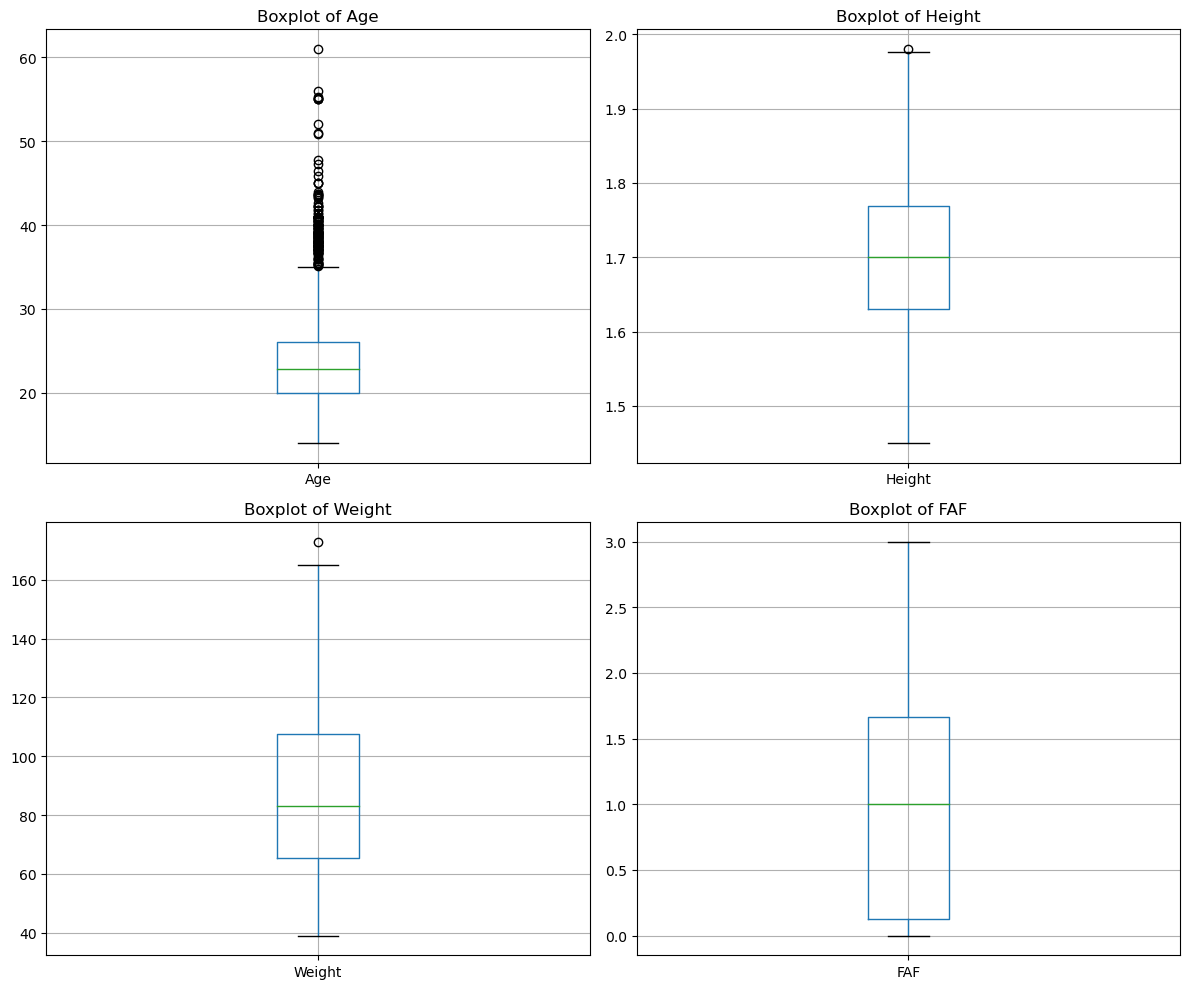

In [14]:
# Analisis distribusi target variable
print("Target Variable Distribution:")
print(obesity['NObeyesdad'].value_counts())
print("\nTarget Variable Percentages:")
print(obesity['NObeyesdad'].value_counts(normalize=True) * 100)

# Cek outliers pada variabel numerik
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, col in enumerate(['Age', 'Height', 'Weight', 'FAF']):
    if i < 4:
        obesity.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


Correlation Analysis:


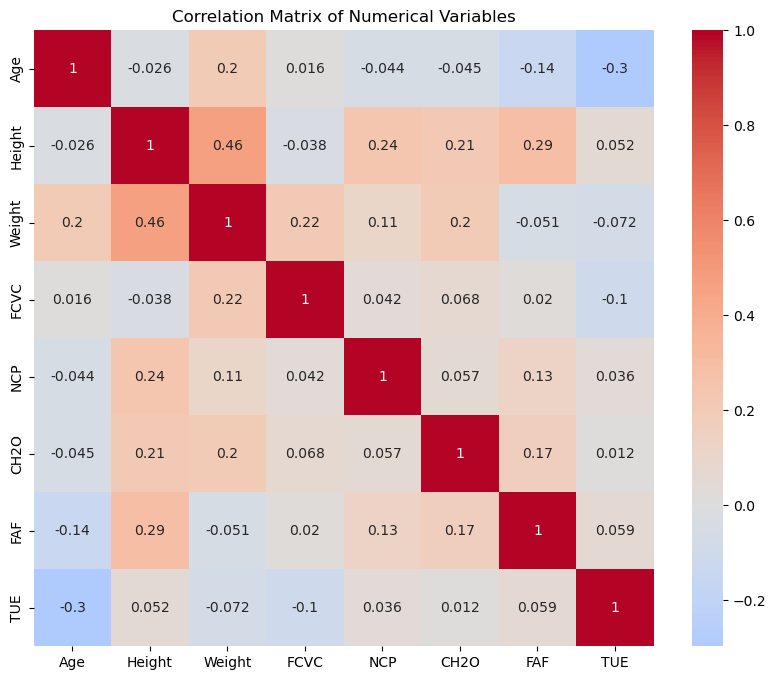


=== CORRELATION WITH CATEGORICAL VARIABLES ===

1. CATEGORICAL-CATEGORICAL CORRELATION (Cramér's V)

Cramér's V Matrix:
                                Gender  family_history_with_overweight   FAVC  \
Gender                           1.000                           0.099  0.060   
family_history_with_overweight   0.099                           1.000  0.205   
FAVC                             0.060                           0.205  1.000   
CAEC                             0.131                           0.349  0.193   
SMOKE                            0.035                           0.000  0.040   
SCC                              0.098                           0.181  0.186   
CALC                             0.033                           0.012  0.137   
MTRANS                           0.162                           0.118  0.201   
NObeyesdad                       0.556                           0.540  0.328   

                                 CAEC  SMOKE    SCC   CALC  MTRANS  

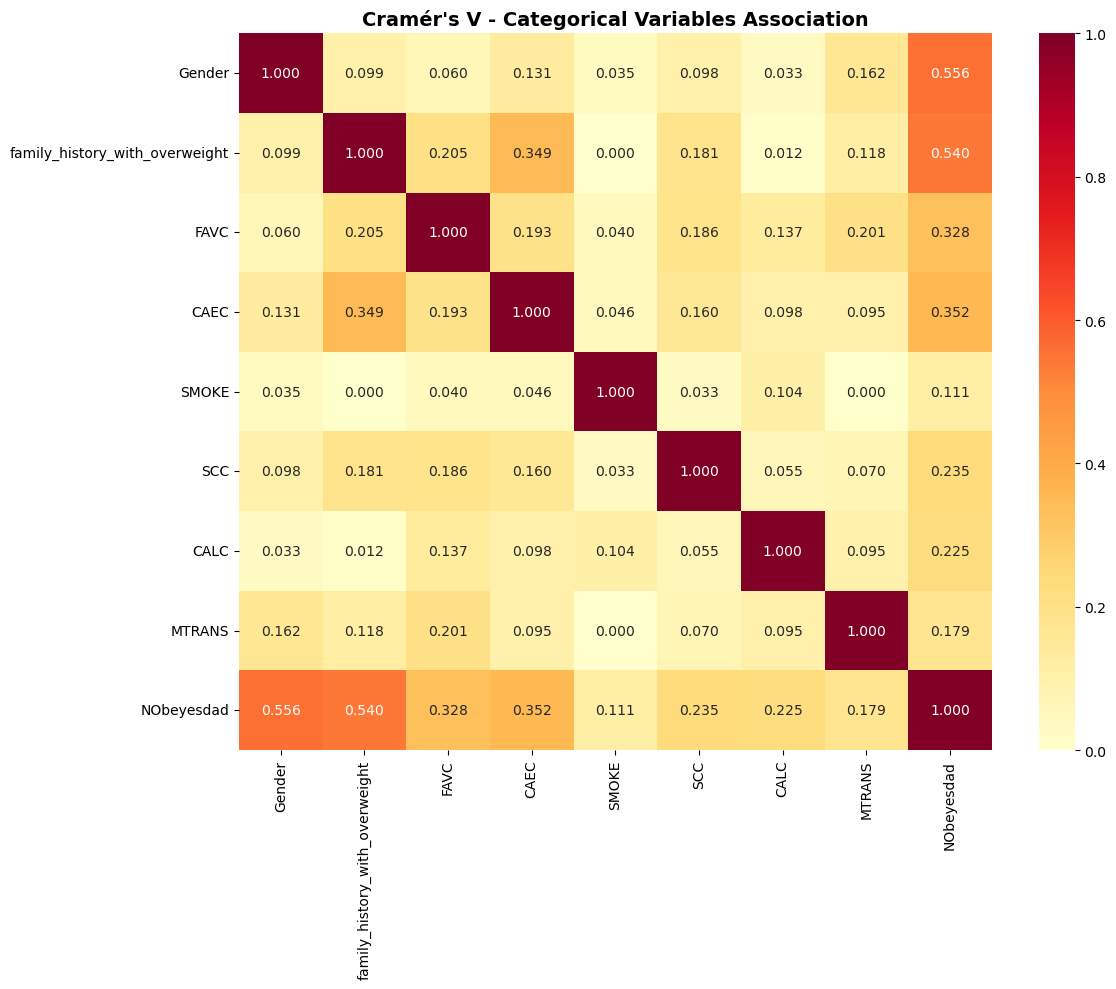


Strongest Categorical Associations (Cramér's V > 0.3):
  Gender - NObeyesdad: 0.556
  family_history_with_overweight - CAEC: 0.349
  family_history_with_overweight - NObeyesdad: 0.540
  FAVC - NObeyesdad: 0.328
  CAEC - NObeyesdad: 0.352

2. NUMERICAL-CATEGORICAL CORRELATION

Numerical-Categorical Correlation Matrix:
(Point Biserial for binary, Correlation Ratio for multi-category)
        Gender  family_history_with_overweight   FAVC   CAEC  SMOKE    SCC  \
Age      0.048                           0.206  0.064  0.146  0.092 -0.116   
Height   0.618                           0.248  0.178  0.160  0.055 -0.134   
Weight   0.162                           0.497  0.272  0.419  0.026 -0.202   
FCVC    -0.275                           0.040 -0.027  0.114  0.014  0.072   
NCP      0.068                           0.071 -0.007  0.154  0.008 -0.016   
CH2O     0.108                           0.147  0.010  0.206 -0.032  0.008   
FAF      0.190                          -0.057 -0.108  0.050  0.011 

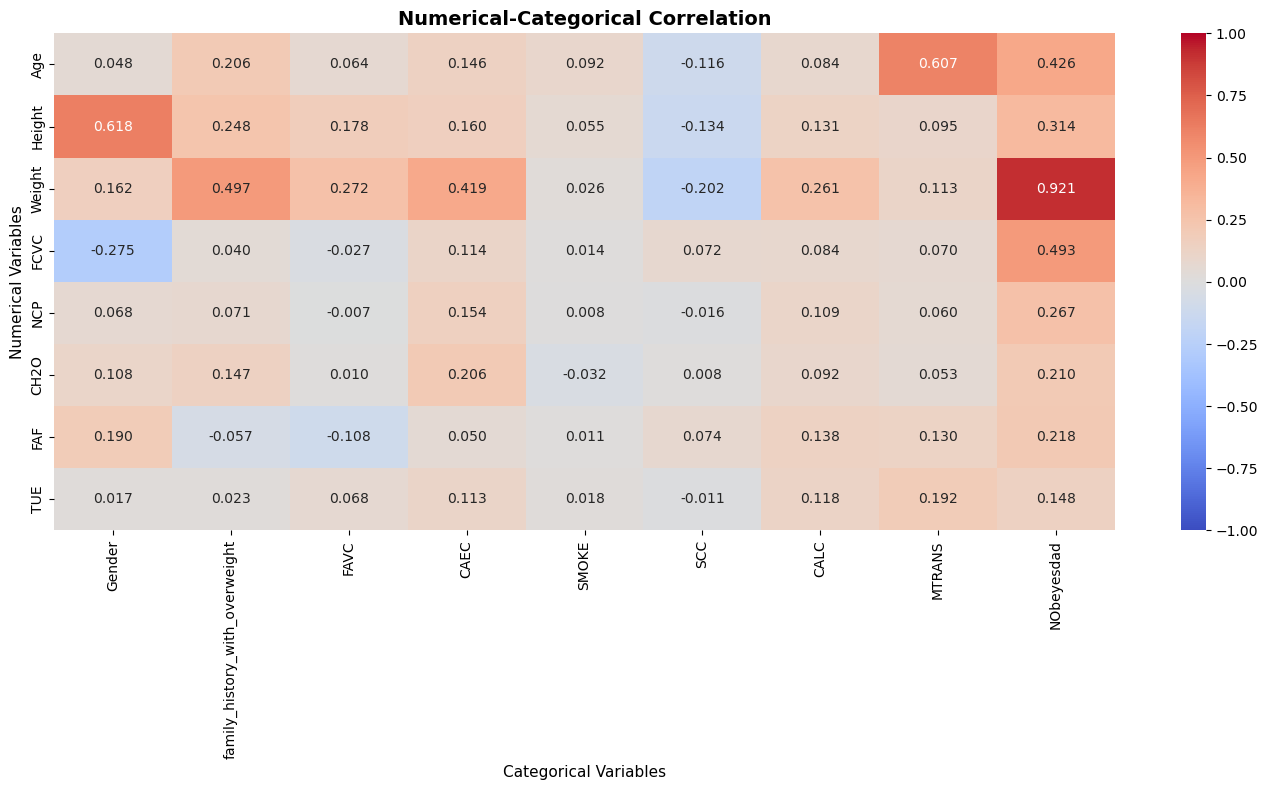


Strongest Numerical-Categorical Correlations (|r| > 0.3):
  Age - MTRANS: 0.607
  Age - NObeyesdad: 0.426
  Height - Gender: 0.618
  Height - NObeyesdad: 0.314
  Weight - family_history_with_overweight: 0.497
  Weight - CAEC: 0.419
  Weight - NObeyesdad: 0.921
  FCVC - NObeyesdad: 0.493

3. CATEGORICAL VARIABLES VS TARGET

Association with Target Variable (NObeyesdad):

Gender:
  Cramér's V: 0.556
  Chi-Square: 657.75
  p-value: 0.000000
  ✓ Significant association with target (p < 0.05)

family_history_with_overweight:
  Cramér's V: 0.540
  Chi-Square: 621.98
  p-value: 0.000000
  ✓ Significant association with target (p < 0.05)

FAVC:
  Cramér's V: 0.328
  Chi-Square: 233.34
  p-value: 0.000000
  ✓ Significant association with target (p < 0.05)

CAEC:
  Cramér's V: 0.352
  Chi-Square: 802.98
  p-value: 0.000000
  ✓ Significant association with target (p < 0.05)

SMOKE:
  Cramér's V: 0.111
  Chi-Square: 32.14
  p-value: 0.000015
  ✓ Significant association with target (p < 0.05)

SCC

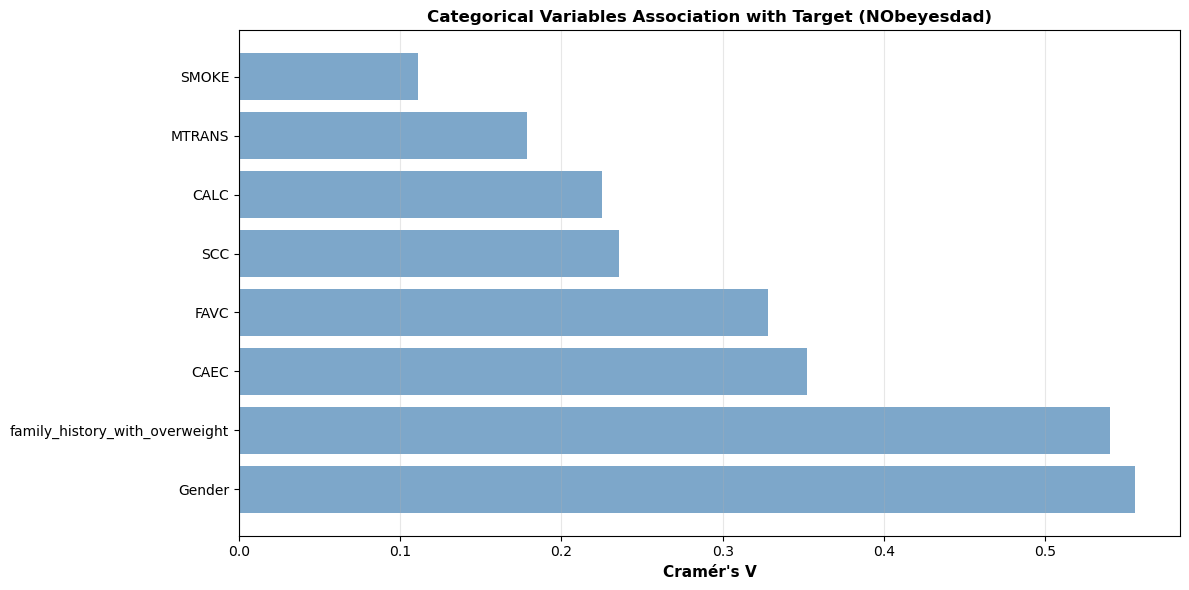


4. NORMALITY TEST (Shapiro-Wilk)

Age: p-value = 0.000000
  ⚠ Age does not follow normal distribution

Height: p-value = 0.000000
  ⚠ Height does not follow normal distribution

Weight: p-value = 0.000000
  ⚠ Weight does not follow normal distribution


In [15]:
# Analisis korelasi antar variabel numerik
print("\nCorrelation Analysis:")
numerical_data = obesity.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()

# Visualisasi korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# === CORRELATION WITH CATEGORICAL VARIABLES ===
print("\n=== CORRELATION WITH CATEGORICAL VARIABLES ===\n")

from scipy.stats import chi2_contingency, pointbiserialr
from scipy.stats.contingency import association

def cramers_v(confusion_matrix):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Get categorical columns
categorical_cols = obesity.select_dtypes(include=['object']).columns.tolist()
numerical_cols = obesity.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("1. CATEGORICAL-CATEGORICAL CORRELATION (Cramér's V)")
print("="*70)

# Calculate Cramér's V for all categorical pairs
if len(categorical_cols) > 1:
    cramer_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))), 
                                  index=categorical_cols, 
                                  columns=categorical_cols)
    
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                cramer_matrix.loc[col1, col2] = 1.0
            else:
                confusion_mat = pd.crosstab(obesity[col1], obesity[col2])
                cramer_matrix.loc[col1, col2] = cramers_v(confusion_mat.values)
    
    print("\nCramér's V Matrix:")
    print(cramer_matrix.round(3))
    
    # Visualize Cramér's V
    plt.figure(figsize=(12, 10))
    sns.heatmap(cramer_matrix.astype(float), annot=True, fmt='.3f', 
                cmap='YlOrRd', center=0.5, vmin=0, vmax=1)
    plt.title("Cramér's V - Categorical Variables Association", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show strongest associations
    print("\nStrongest Categorical Associations (Cramér's V > 0.3):")
    for i in range(len(categorical_cols)):
        for j in range(i+1, len(categorical_cols)):
            col1, col2 = categorical_cols[i], categorical_cols[j]
            v = cramer_matrix.loc[col1, col2]
            if v > 0.3:
                print(f"  {col1} - {col2}: {v:.3f}")

print("\n" + "="*70)
print("2. NUMERICAL-CATEGORICAL CORRELATION")
print("="*70)

# Calculate correlation between numerical and categorical variables
num_cat_corr = pd.DataFrame(index=numerical_cols, columns=categorical_cols)

for num_col in numerical_cols:
    for cat_col in categorical_cols:
        # For binary categorical: use point biserial correlation
        if obesity[cat_col].nunique() == 2:
            # Encode binary categorical as 0/1
            cat_encoded = LabelEncoder().fit_transform(obesity[cat_col])
            corr, p_value = pointbiserialr(cat_encoded, obesity[num_col])
            num_cat_corr.loc[num_col, cat_col] = corr
        else:
            # For multi-category: use correlation ratio (eta squared)
            categories = obesity[cat_col].unique()
            cat_groups = [obesity[obesity[cat_col] == cat][num_col].values for cat in categories]
            
            # Calculate eta squared
            grand_mean = obesity[num_col].mean()
            ss_between = sum(len(group) * (group.mean() - grand_mean)**2 for group in cat_groups)
            ss_total = sum((obesity[num_col] - grand_mean)**2)
            eta_squared = ss_between / ss_total if ss_total > 0 else 0
            num_cat_corr.loc[num_col, cat_col] = np.sqrt(eta_squared)  # Correlation ratio

num_cat_corr = num_cat_corr.astype(float)

print("\nNumerical-Categorical Correlation Matrix:")
print("(Point Biserial for binary, Correlation Ratio for multi-category)")
print(num_cat_corr.round(3))

# Visualize numerical-categorical correlation
plt.figure(figsize=(14, 8))
sns.heatmap(num_cat_corr, annot=True, fmt='.3f', 
            cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Numerical-Categorical Correlation', fontsize=14, fontweight='bold')
plt.xlabel('Categorical Variables', fontsize=11)
plt.ylabel('Numerical Variables', fontsize=11)
plt.tight_layout()
plt.show()

# Show strongest correlations
print("\nStrongest Numerical-Categorical Correlations (|r| > 0.3):")
for num_col in numerical_cols:
    for cat_col in categorical_cols:
        corr_val = abs(num_cat_corr.loc[num_col, cat_col])
        if corr_val > 0.3:
            print(f"  {num_col} - {cat_col}: {num_cat_corr.loc[num_col, cat_col]:.3f}")

print("\n" + "="*70)
print("3. CATEGORICAL VARIABLES VS TARGET")
print("="*70)

# Analyze categorical variables against target
target_col = 'NObeyesdad'
cat_cols_without_target = [col for col in categorical_cols if col != target_col]

print(f"\nAssociation with Target Variable ({target_col}):")
target_associations = {}

for cat_col in cat_cols_without_target:
    confusion_mat = pd.crosstab(obesity[cat_col], obesity[target_col])
    cramers = cramers_v(confusion_mat.values)
    chi2, p_value = chi2_contingency(confusion_mat)[:2]
    
    target_associations[cat_col] = {
        'Cramers_V': cramers,
        'Chi2': chi2,
        'p_value': p_value
    }
    
    print(f"\n{cat_col}:")
    print(f"  Cramér's V: {cramers:.3f}")
    print(f"  Chi-Square: {chi2:.2f}")
    print(f"  p-value: {p_value:.6f}")
    if p_value < 0.05:
        print(f"  ✓ Significant association with target (p < 0.05)")
    else:
        print(f"  ✗ Not significant (p >= 0.05)")

# Visualize associations with target
associations_df = pd.DataFrame(target_associations).T
associations_df = associations_df.sort_values('Cramers_V', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(range(len(associations_df)), associations_df['Cramers_V'].values, 
         color='steelblue', alpha=0.7)
plt.yticks(range(len(associations_df)), associations_df.index)
plt.xlabel("Cramér's V", fontsize=11, fontweight='bold')
plt.title(f'Categorical Variables Association with Target ({target_col})', 
          fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Cek normalitas distribusi untuk variabel kunci
from scipy import stats

key_variables = ['Age', 'Height', 'Weight', 'BMI'] if 'BMI' in obesity.columns else ['Age', 'Height', 'Weight']
print("\n" + "="*70)
print("4. NORMALITY TEST (Shapiro-Wilk)")
print("="*70)
for var in key_variables:
    if var in obesity.columns:
        stat, p_value = stats.shapiro(obesity[var].sample(min(5000, len(obesity))))
        print(f"\n{var}: p-value = {p_value:.6f}")
        if p_value > 0.05:
            print(f"  ✓ {var} likely follows normal distribution")
        else:
            print(f"  ⚠ {var} does not follow normal distribution")


=== CAEC vs NObeyesdad ANALYSIS ===

Crosstab: CAEC vs NObeyesdad
NObeyesdad  Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
CAEC                                                             
Always                        2             35               6   
Frequently                  121             83               6   
Sometimes                   146            159             338   
no                            3             10               1   
All                         272            287             351   

NObeyesdad  Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
CAEC                                                                
Always                    2                 0                   5   
Frequently                1                 1                  14   
Sometimes               293               323                 236   
no                        1                 0                  35   
All                     297               324           

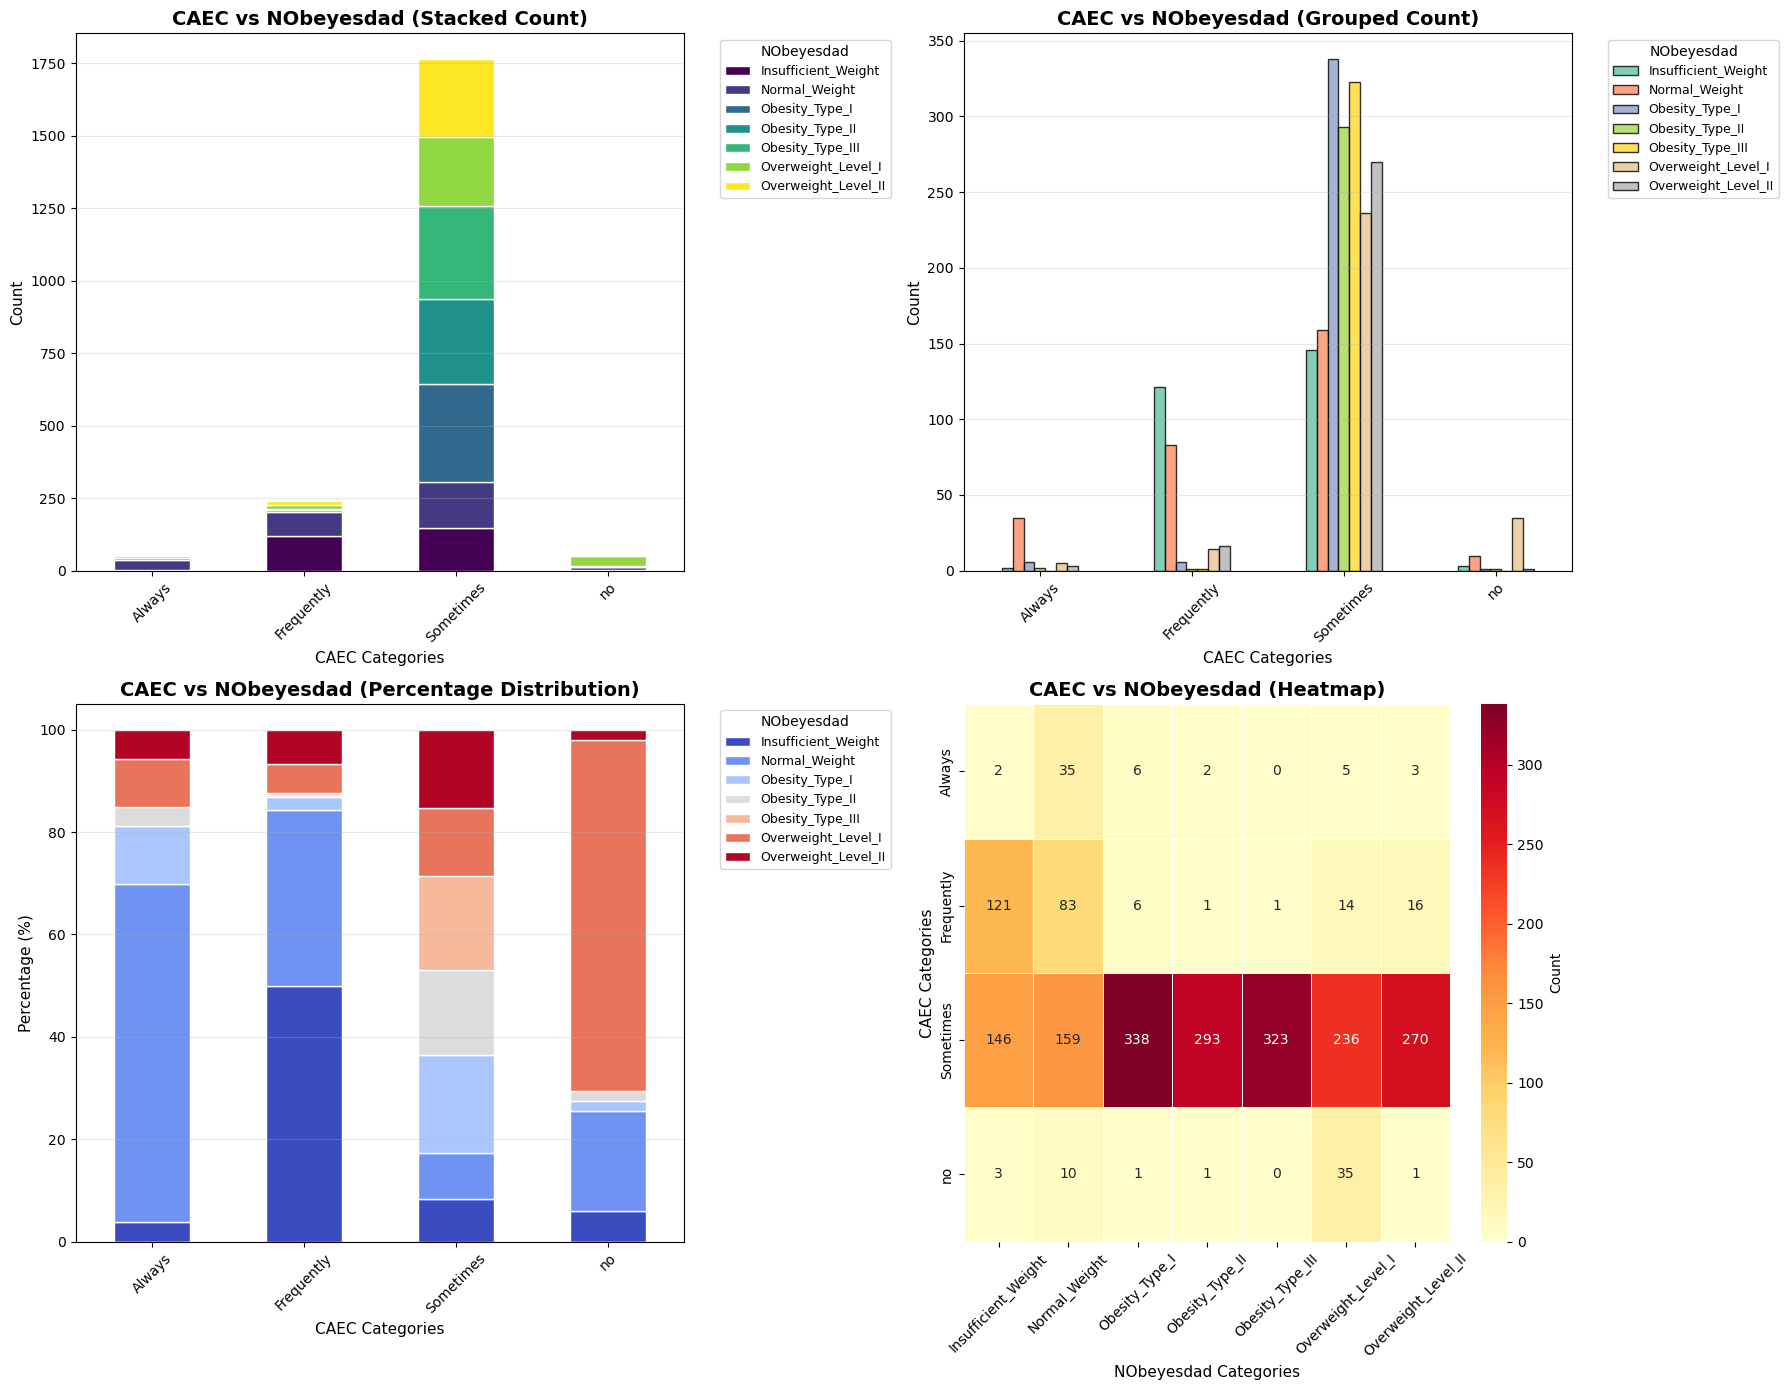


DETAILED ANALYSIS BY CAEC CATEGORY

Sometimes:
  Total samples: 1765
  Most common obesity level: Obesity_Type_I (19.1%)
  Distribution:
    - Obesity_Type_I: 338 (19.2%)
    - Obesity_Type_III: 323 (18.3%)
    - Obesity_Type_II: 293 (16.6%)
    - Overweight_Level_II: 270 (15.3%)
    - Overweight_Level_I: 236 (13.4%)
    - Normal_Weight: 159 (9.0%)
    - Insufficient_Weight: 146 (8.3%)

Frequently:
  Total samples: 242
  Most common obesity level: Insufficient_Weight (50.0%)
  Distribution:
    - Insufficient_Weight: 121 (50.0%)
    - Normal_Weight: 83 (34.3%)
    - Overweight_Level_II: 16 (6.6%)
    - Overweight_Level_I: 14 (5.8%)
    - Obesity_Type_I: 6 (2.5%)
    - Obesity_Type_II: 1 (0.4%)
    - Obesity_Type_III: 1 (0.4%)

Always:
  Total samples: 53
  Most common obesity level: Normal_Weight (66.0%)
  Distribution:
    - Normal_Weight: 35 (66.0%)
    - Obesity_Type_I: 6 (11.3%)
    - Overweight_Level_I: 5 (9.4%)
    - Overweight_Level_II: 3 (5.7%)
    - Obesity_Type_II: 2 (3.8%)


In [16]:
# === RELATIONSHIP BETWEEN CAEC AND NOBEYESDAD ===
print("\n=== CAEC vs NObeyesdad ANALYSIS ===\n")

# 1. Crosstab Analysis
caec_obesity_crosstab = pd.crosstab(obesity['CAEC'], obesity['NObeyesdad'], margins=True)
print("Crosstab: CAEC vs NObeyesdad")
print(caec_obesity_crosstab)
print()

# 2. Normalized Crosstab (Percentage by CAEC)
caec_obesity_pct = pd.crosstab(obesity['CAEC'], obesity['NObeyesdad'], normalize='index') * 100
print("\nPercentage Distribution (by CAEC category):")
print(caec_obesity_pct.round(2))
print()

# 3. Chi-Square Test
from scipy.stats import chi2_contingency

chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(obesity['CAEC'], obesity['NObeyesdad']))
print(f"\nChi-Square Test:")
print(f"  Chi-Square Statistic: {chi2:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Degrees of Freedom: {dof}")
if p_value < 0.05:
    print(f"  ✓ Significant association (p < 0.05)")
else:
    print(f"  ✗ Not significant (p >= 0.05)")

# 4. Cramér's V
cramers = cramers_v(pd.crosstab(obesity['CAEC'], obesity['NObeyesdad']).values)
print(f"\nCramér's V: {cramers:.4f}")
if cramers > 0.3:
    print("  Strong association")
elif cramers > 0.1:
    print("  Moderate association")
else:
    print("  Weak association")

# === VISUALIZATIONS ===
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Stacked Bar Chart (Count)
caec_obesity_crosstab_no_margin = pd.crosstab(obesity['CAEC'], obesity['NObeyesdad'])
caec_obesity_crosstab_no_margin.plot(kind='bar', stacked=True, ax=axes[0, 0], 
                                      colormap='viridis', edgecolor='white')
axes[0, 0].set_title('CAEC vs NObeyesdad (Stacked Count)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('CAEC Categories', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].legend(title='NObeyesdad', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Grouped Bar Chart
caec_obesity_crosstab_no_margin.plot(kind='bar', ax=axes[0, 1], 
                                      colormap='Set2', edgecolor='black', alpha=0.8)
axes[0, 1].set_title('CAEC vs NObeyesdad (Grouped Count)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('CAEC Categories', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].legend(title='NObeyesdad', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Normalized Stacked Bar (100%)
caec_obesity_pct.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                      colormap='coolwarm', edgecolor='white')
axes[1, 0].set_title('CAEC vs NObeyesdad (Percentage Distribution)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('CAEC Categories', fontsize=11)
axes[1, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 0].legend(title='NObeyesdad', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Heatmap
sns.heatmap(caec_obesity_crosstab_no_margin, annot=True, fmt='d', cmap='YlOrRd', 
            ax=axes[1, 1], cbar_kws={'label': 'Count'}, linewidths=0.5)
axes[1, 1].set_title('CAEC vs NObeyesdad (Heatmap)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('NObeyesdad Categories', fontsize=11)
axes[1, 1].set_ylabel('CAEC Categories', fontsize=11)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# === ADDITIONAL ANALYSIS ===
print("\n" + "="*70)
print("DETAILED ANALYSIS BY CAEC CATEGORY")
print("="*70)

for caec_cat in obesity['CAEC'].unique():
    print(f"\n{caec_cat}:")
    subset = obesity[obesity['CAEC'] == caec_cat]
    obesity_dist = subset['NObeyesdad'].value_counts()
    obesity_pct = (obesity_dist / len(subset) * 100).round(2)
    
    print(f"  Total samples: {len(subset)}")
    print(f"  Most common obesity level: {obesity_dist.index[0]} ({obesity_pct.iloc[0]:.1f}%)")
    print(f"  Distribution:")
    for level, count in obesity_dist.items():
        pct = (count / len(subset) * 100)
        print(f"    - {level}: {count} ({pct:.1f}%)")

# === REVERSE ANALYSIS ===
print("\n" + "="*70)
print("REVERSE ANALYSIS: NObeyesdad BY CAEC")
print("="*70)

for obesity_level in obesity['NObeyesdad'].unique():
    print(f"\n{obesity_level}:")
    subset = obesity[obesity['NObeyesdad'] == obesity_level]
    caec_dist = subset['CAEC'].value_counts()
    caec_pct = (caec_dist / len(subset) * 100).round(2)
    
    print(f"  Total samples: {len(subset)}")
    print(f"  Most common CAEC: {caec_dist.index[0]} ({caec_pct.iloc[0]:.1f}%)")
    print(f"  CAEC Distribution:")
    for caec, count in caec_dist.items():
        pct = (count / len(subset) * 100)
        print(f"    - {caec}: {count} ({pct:.1f}%)")


=== family_history_with_overweight vs NObeyesdad ANALYSIS ===

Crosstab: family_history_with_overweight vs NObeyesdad
NObeyesdad                      Insufficient_Weight  Normal_Weight  \
family_history_with_overweight                                       
no                                              146            132   
yes                                             126            155   
All                                             272            287   

NObeyesdad                      Obesity_Type_I  Obesity_Type_II  \
family_history_with_overweight                                    
no                                           7                1   
yes                                        344              296   
All                                        351              297   

NObeyesdad                      Obesity_Type_III  Overweight_Level_I  \
family_history_with_overweight                                         
no                                             0  

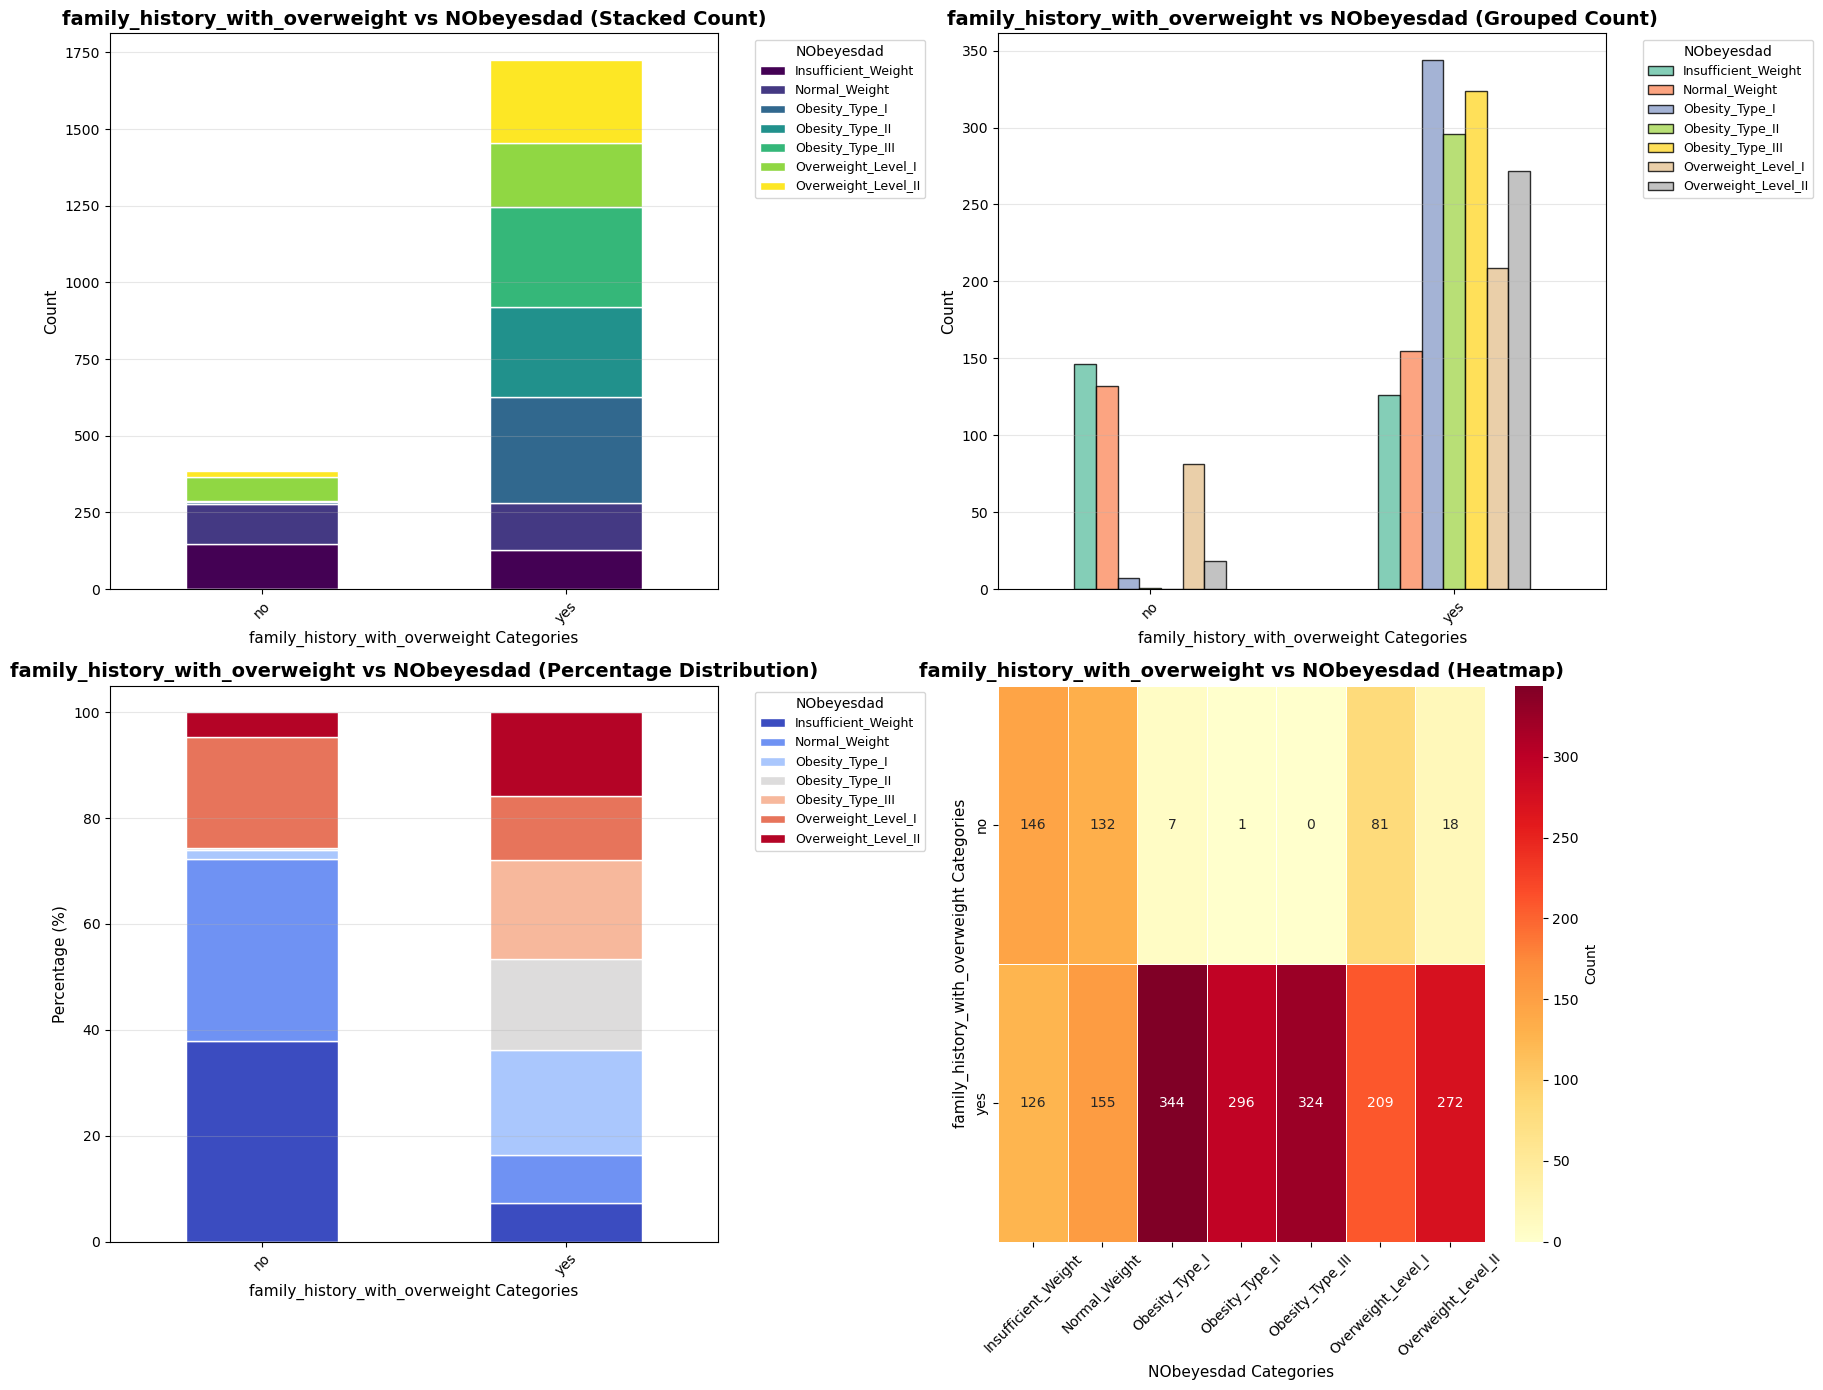


DETAILED ANALYSIS BY FAMILY_HISTORY_WITH_OVERWEIGHT CATEGORY

yes:
  Total samples: 1726
  Most common obesity level: Obesity_Type_I (19.9%)
  Distribution:
    - Obesity_Type_I: 344 (19.9%)
    - Obesity_Type_III: 324 (18.8%)
    - Obesity_Type_II: 296 (17.1%)
    - Overweight_Level_II: 272 (15.8%)
    - Overweight_Level_I: 209 (12.1%)
    - Normal_Weight: 155 (9.0%)
    - Insufficient_Weight: 126 (7.3%)

no:
  Total samples: 385
  Most common obesity level: Insufficient_Weight (37.9%)
  Distribution:
    - Insufficient_Weight: 146 (37.9%)
    - Normal_Weight: 132 (34.3%)
    - Overweight_Level_I: 81 (21.0%)
    - Overweight_Level_II: 18 (4.7%)
    - Obesity_Type_I: 7 (1.8%)
    - Obesity_Type_II: 1 (0.3%)

REVERSE ANALYSIS: NObeyesdad BY FAMILY_HISTORY_WITH_OVERWEIGHT

Normal_Weight:
  Total samples: 287
  Most common family_history_with_overweight: yes (54.0%)
  family_history_with_overweight Distribution:
    - yes: 155 (54.0%)
    - no: 132 (46.0%)

Overweight_Level_I:
  Total sa

In [17]:
# === RELATIONSHIP BETWEEN FAMILY_HISTORY_WITH_OVERWEIGHT AND NOBEYESDAD ===
print("\n=== family_history_with_overweight vs NObeyesdad ANALYSIS ===\n")

# 1. Crosstab Analysis
history_obesity_crosstab = pd.crosstab(obesity['family_history_with_overweight'], obesity['NObeyesdad'], margins=True)
print("Crosstab: family_history_with_overweight vs NObeyesdad")
print(history_obesity_crosstab)
print()

# 2. Normalized Crosstab (Percentage by family_history_with_overweight)
history_obesity_pct = pd.crosstab(obesity['family_history_with_overweight'], obesity['NObeyesdad'], normalize='index') * 100
print("\nPercentage Distribution (by family_history_with_overweight category):")
print(history_obesity_pct.round(2))
print()

# 3. Chi-Square Test
from scipy.stats import chi2_contingency

chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(obesity['family_history_with_overweight'], obesity['NObeyesdad']))
print(f"\nChi-Square Test:")
print(f"  Chi-Square Statistic: {chi2:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Degrees of Freedom: {dof}")
if p_value < 0.05:
    print(f"  ✓ Significant association (p < 0.05)")
else:
    print(f"  ✗ Not significant (p >= 0.05)")

# 4. Cramér's V
cramers = cramers_v(pd.crosstab(obesity['family_history_with_overweight'], obesity['NObeyesdad']).values)
print(f"\nCramér's V: {cramers:.4f}")
if cramers > 0.3:
    print("  Strong association")
elif cramers > 0.1:
    print("  Moderate association")
else:
    print("  Weak association")

# === VISUALIZATIONS ===
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Stacked Bar Chart (Count)
history_obesity_crosstab_no_margin = pd.crosstab(obesity['family_history_with_overweight'], obesity['NObeyesdad'])
history_obesity_crosstab_no_margin.plot(kind='bar', stacked=True, ax=axes[0, 0], 
                                      colormap='viridis', edgecolor='white')
axes[0, 0].set_title('family_history_with_overweight vs NObeyesdad (Stacked Count)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('family_history_with_overweight Categories', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].legend(title='NObeyesdad', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Grouped Bar Chart
history_obesity_crosstab_no_margin.plot(kind='bar', ax=axes[0, 1], 
                                      colormap='Set2', edgecolor='black', alpha=0.8)
axes[0, 1].set_title('family_history_with_overweight vs NObeyesdad (Grouped Count)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('family_history_with_overweight Categories', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].legend(title='NObeyesdad', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Normalized Stacked Bar (100%)
history_obesity_pct.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                      colormap='coolwarm', edgecolor='white')
axes[1, 0].set_title('family_history_with_overweight vs NObeyesdad (Percentage Distribution)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('family_history_with_overweight Categories', fontsize=11)
axes[1, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 0].legend(title='NObeyesdad', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Heatmap
sns.heatmap(history_obesity_crosstab_no_margin, annot=True, fmt='d', cmap='YlOrRd', 
            ax=axes[1, 1], cbar_kws={'label': 'Count'}, linewidths=0.5)
axes[1, 1].set_title('family_history_with_overweight vs NObeyesdad (Heatmap)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('NObeyesdad Categories', fontsize=11)
axes[1, 1].set_ylabel('family_history_with_overweight Categories', fontsize=11)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# === ADDITIONAL ANALYSIS ===
print("\n" + "="*70)
print("DETAILED ANALYSIS BY FAMILY_HISTORY_WITH_OVERWEIGHT CATEGORY")
print("="*70)

for history_cat in obesity['family_history_with_overweight'].unique():
    print(f"\n{history_cat}:")
    subset = obesity[obesity['family_history_with_overweight'] == history_cat]
    obesity_dist = subset['NObeyesdad'].value_counts()
    obesity_pct = (obesity_dist / len(subset) * 100).round(2)
    
    print(f"  Total samples: {len(subset)}")
    print(f"  Most common obesity level: {obesity_dist.index[0]} ({obesity_pct.iloc[0]:.1f}%)")
    print(f"  Distribution:")
    for level, count in obesity_dist.items():
        pct = (count / len(subset) * 100)
        print(f"    - {level}: {count} ({pct:.1f}%)")

# === REVERSE ANALYSIS ===
print("\n" + "="*70)
print("REVERSE ANALYSIS: NObeyesdad BY FAMILY_HISTORY_WITH_OVERWEIGHT")
print("="*70)

for obesity_level in obesity['NObeyesdad'].unique():
    print(f"\n{obesity_level}:")
    subset = obesity[obesity['NObeyesdad'] == obesity_level]
    history_dist = subset['family_history_with_overweight'].value_counts()
    history_pct = (history_dist / len(subset) * 100).round(2)
    
    print(f"  Total samples: {len(subset)}")
    print(f"  Most common family_history_with_overweight: {history_dist.index[0]} ({history_pct.iloc[0]:.1f}%)")
    print(f"  family_history_with_overweight Distribution:")
    for history, count in history_dist.items():
        pct = (count / len(subset) * 100)
        print(f"    - {history}: {count} ({pct:.1f}%)")


**Data Preparation**

In [14]:
# Create working copy
df_processed = obesity.copy()

print("=== FEATURE ENGINEERING ===")

# 1. Create BMI feature
df_processed['BMI'] = df_processed['Weight'] / (df_processed['Height'] ** 2)
print("✓ BMI feature created")

# 2. Create age groups
def categorize_age(age):
    if age < 25:
        return 'Young'
    elif age < 40:
        return 'Adult'
    else:
        return 'Middle_Aged'

df_processed['Age_Group'] = df_processed['Age'].apply(categorize_age)
print("✓ Age groups created")

# 3. Create BMI categories (WHO standards)
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df_processed['BMI_Category'] = df_processed['BMI'].apply(categorize_bmi)
print("✓ BMI categories created")

# 4. Create lifestyle score
df_processed['Lifestyle_Score'] = (
    df_processed['FAF'] * 2 +  # Physical activity weight more
    df_processed['FCVC'] +     # Vegetable consumption
    df_processed['CH2O'] -     # Water consumption (positive)
    df_processed['NCP'] * 0.5 - # Number of meals (moderate weight)
    df_processed['TUE'] * 0.5   # Technology use (negative weight)
)
print("✓ Lifestyle score created")

print(f"\nNew dataset shape: {df_processed.shape}")
print(f"Added features: BMI, Age_Group, BMI_Category, Lifestyle_Score")

=== FEATURE ENGINEERING ===
✓ BMI feature created
✓ Age groups created
✓ BMI categories created
✓ Lifestyle score created

New dataset shape: (2111, 21)
Added features: BMI, Age_Group, BMI_Category, Lifestyle_Score


In [15]:
print("=== CATEGORICAL VARIABLES ENCODING ===")

# Identify categorical columns (excluding target)
categorical_columns = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')  # Remove target variable

print(f"Categorical columns to encode: {categorical_columns}")

# Create copy for encoding
df_encoded = df_processed.copy()

# Dictionary to store encoders
encoders = {}

# Encode each categorical variable
for col in categorical_columns:
    unique_vals = df_encoded[col].nunique()
    print(f"\nEncoding {col} ({unique_vals} unique values)")
    
    if unique_vals <= 3:
        # Use One-Hot Encoding for variables with few categories
        encoded_cols = pd.get_dummies(df_encoded[col], prefix=col)
        df_encoded = pd.concat([df_encoded, encoded_cols], axis=1)
        df_encoded.drop(col, axis=1, inplace=True)
        print(f"✓ One-hot encoded: {list(encoded_cols.columns)}")
    else:
        # Use Label Encoding for variables with many categories
        le = LabelEncoder()
        df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
        encoders[col] = le
        df_encoded.drop(col, axis=1, inplace=True)
        print(f"✓ Label encoded: {col}_encoded")

print(f"\nShape after encoding: {df_encoded.shape}")

=== CATEGORICAL VARIABLES ENCODING ===
Categorical columns to encode: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Age_Group', 'BMI_Category']

Encoding Gender (2 unique values)
✓ One-hot encoded: ['Gender_Female', 'Gender_Male']

Encoding family_history_with_overweight (2 unique values)
✓ One-hot encoded: ['family_history_with_overweight_no', 'family_history_with_overweight_yes']

Encoding FAVC (2 unique values)
✓ One-hot encoded: ['FAVC_no', 'FAVC_yes']

Encoding CAEC (4 unique values)
✓ Label encoded: CAEC_encoded

Encoding SMOKE (2 unique values)
✓ One-hot encoded: ['SMOKE_no', 'SMOKE_yes']

Encoding SCC (2 unique values)
✓ One-hot encoded: ['SCC_no', 'SCC_yes']

Encoding CALC (4 unique values)
✓ Label encoded: CALC_encoded

Encoding MTRANS (5 unique values)
✓ Label encoded: MTRANS_encoded

Encoding Age_Group (3 unique values)
✓ One-hot encoded: ['Age_Group_Adult', 'Age_Group_Middle_Aged', 'Age_Group_Young']

Encoding BMI_Category 

In [14]:
print("=== TARGET VARIABLE PREPARATION ===")

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(df_processed['NObeyesdad'])

# Display class mapping
class_mapping = dict(zip(target_encoder.classes_, range(len(target_encoder.classes_))))
print("Class mapping:")
for class_name, class_id in class_mapping.items():
    count = (y_encoded == class_id).sum()
    percentage = (count / len(y_encoded)) * 100
    print(f"  {class_id}: {class_name} ({count} samples, {percentage:.1f}%)")

# Remove target from features
X = df_encoded.drop('NObeyesdad', axis=1)
y = y_encoded

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of classes: {len(target_encoder.classes_)}")

=== TARGET VARIABLE PREPARATION ===
Class mapping:
  0: Insufficient_Weight (272 samples, 12.9%)
  1: Normal_Weight (287 samples, 13.6%)
  2: Obesity_Type_I (351 samples, 16.6%)
  3: Obesity_Type_II (297 samples, 14.1%)
  4: Obesity_Type_III (324 samples, 15.3%)
  5: Overweight_Level_I (290 samples, 13.7%)
  6: Overweight_Level_II (290 samples, 13.7%)

Features shape: (2111, 27)
Target shape: (2111,)
Number of classes: 7


=== FEATURE CORRELATION ANALYSIS ===
Features correlation with target (absolute values):
BMI                     0.429686
Weight                  0.387643
CAEC_encoded            0.327295
Age                     0.236170
CALC_encoded            0.134632
FAF                     0.129564
CH2O                    0.108868
NCP                     0.092616
BMI_Category_encoded    0.092334
TUE                     0.069448
MTRANS_encoded          0.046202
Lifestyle_Score         0.043370
Height                  0.038986
FCVC                    0.018522
Name: target, dtype: float64


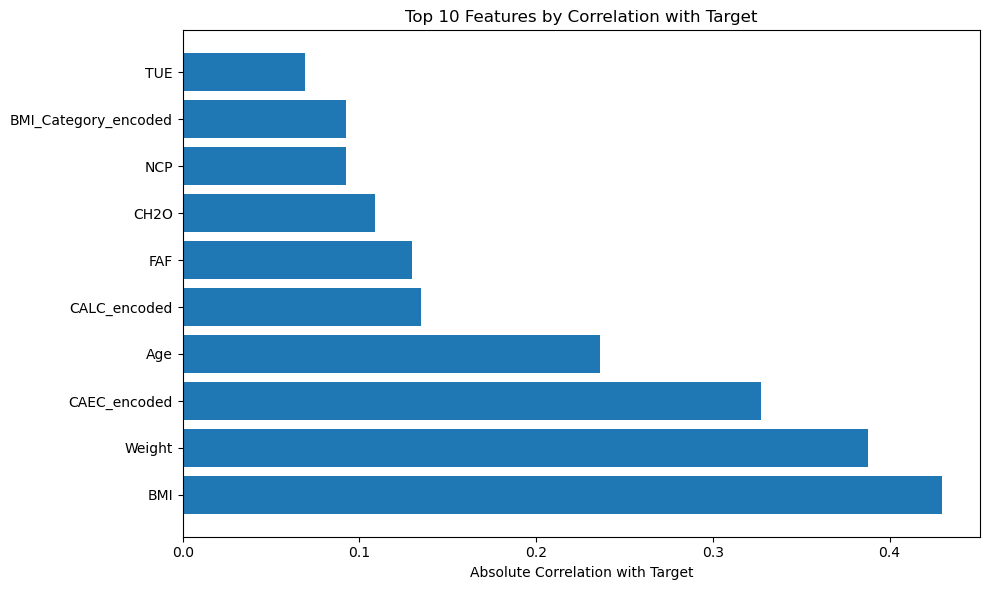


High correlation pairs (>0.8): 2
  Weight - BMI: 0.935
  FAF - Lifestyle_Score: 0.874


In [15]:
print("=== FEATURE CORRELATION ANALYSIS ===")

# Calculate correlation with target
numerical_features = X.select_dtypes(include=[np.number]).columns

# Create temporary dataframe for correlation analysis
temp_df = X[numerical_features].copy()
temp_df['target'] = y

# Calculate correlation with target
target_correlation = temp_df.corr()['target'].abs().sort_values(ascending=False)
target_correlation = target_correlation.drop('target')

print("Features correlation with target (absolute values):")
print(target_correlation)

# Visualize top correlations
plt.figure(figsize=(10, 6))
top_features = target_correlation.head(10)
plt.barh(range(len(top_features)), top_features.values)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Target')
plt.title('Top 10 Features by Correlation with Target')
plt.tight_layout()
plt.show()

# Remove highly correlated features (multicollinearity)
correlation_matrix = X[numerical_features].corr()
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print(f"\nHigh correlation pairs (>0.8): {len(high_corr_pairs)}")
    for col1, col2, corr in high_corr_pairs:
        print(f"  {col1} - {col2}: {corr:.3f}")
else:
    print("\n✓ No highly correlated features found")

In [16]:
print("=== FEATURE SCALING ===")

# Separate numerical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [col for col in X.columns if col not in numerical_features]

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Initialize scalers
scaler = StandardScaler()

# Create scaled dataset
X_scaled = X.copy()

# Scale only numerical features
if numerical_features:
    X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])
    print("✓ Numerical features scaled using StandardScaler")

# Display scaling statistics
print("\nScaling statistics:")
print(f"Original numerical features mean: {X[numerical_features].mean().mean():.3f}")
print(f"Scaled numerical features mean: {X_scaled[numerical_features].mean().mean():.3f}")
print(f"Original numerical features std: {X[numerical_features].std().mean():.3f}")
print(f"Scaled numerical features std: {X_scaled[numerical_features].std().mean():.3f}")

=== FEATURE SCALING ===
Numerical features: 14
Categorical features: 13
✓ Numerical features scaled using StandardScaler

Scaling statistics:
Original numerical features mean: 11.695
Scaled numerical features mean: -0.000
Original numerical features std: 3.511
Scaled numerical features std: 1.000


In [17]:
print("=== DATASET SPLITTING ===")

# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.15, 
    stratify=y, 
    random_state=42
)

# Second split: separate train and validation (70% train, 15% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176,  # 0.15/0.85 ≈ 0.176 to get 15% of total
    stratify=y_temp, 
    random_state=42
)

print("Dataset split completed:")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Total features: {X_train.shape[1]}")

# Check class distribution in each split
print("\nClass distribution check:")
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    class_counts = np.bincount(y_split)
    print(f"{split_name}: {class_counts} -> {class_counts/len(y_split)*100}")

=== DATASET SPLITTING ===
Dataset split completed:
  Training set: 1478 samples (70.0%)
  Validation set: 316 samples (15.0%)
  Test set: 317 samples (15.0%)
  Total features: 27

Class distribution check:
Train: [190 201 246 208 227 203 203] -> [12.85520974 13.59945873 16.64411367 14.07307172 15.35859269 13.73477673
 13.73477673]
Validation: [41 43 52 44 48 44 44] -> [12.97468354 13.60759494 16.4556962  13.92405063 15.18987342 13.92405063
 13.92405063]
Test: [41 43 53 45 49 43 43] -> [12.93375394 13.56466877 16.7192429  14.1955836  15.45741325 13.56466877
 13.56466877]


In [18]:
print("=== CLASS IMBALANCE HANDLING ===")

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary format for Keras
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class weights calculated:")
for class_id, weight in class_weight_dict.items():
    class_name = target_encoder.classes_[class_id]
    sample_count = (y_train == class_id).sum()
    print(f"  Class {class_id} ({class_name}): weight={weight:.3f}, samples={sample_count}")

# Alternative: SMOTE for oversampling (optional)
try:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    
    print("\n=== SMOTE OVERSAMPLING (Optional) ===")
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    print(f"Original training set: {X_train.shape[0]} samples")
    print(f"SMOTE training set: {X_train_smote.shape[0]} samples")
    print("Class distribution after SMOTE:")
    unique, counts = np.unique(y_train_smote, return_counts=True)
    for class_id, count in zip(unique, counts):
        print(f"  Class {class_id}: {count} samples")
        
except ImportError:
    print("\nSMOTE not available. Install imbalanced-learn: pip install imbalanced-learn")
    X_train_smote, y_train_smote = X_train, y_train

=== CLASS IMBALANCE HANDLING ===
Class weights calculated:
  Class 0 (Insufficient_Weight): weight=1.111, samples=190
  Class 1 (Normal_Weight): weight=1.050, samples=201
  Class 2 (Obesity_Type_I): weight=0.858, samples=246
  Class 3 (Obesity_Type_II): weight=1.015, samples=208
  Class 4 (Obesity_Type_III): weight=0.930, samples=227
  Class 5 (Overweight_Level_I): weight=1.040, samples=203
  Class 6 (Overweight_Level_II): weight=1.040, samples=203

=== SMOTE OVERSAMPLING (Optional) ===
Original training set: 1478 samples
SMOTE training set: 1722 samples
Class distribution after SMOTE:
  Class 0: 246 samples
  Class 1: 246 samples
  Class 2: 246 samples
  Class 3: 246 samples
  Class 4: 246 samples
  Class 5: 246 samples
  Class 6: 246 samples


In [19]:
print("=== CONVERTING NUMPY TO TENSORFLOW TENSOR ===\n")

# Function to convert numpy arrays to TensorFlow tensors
def convert_to_tensor(data, dtype=tf.float32, name=None):
    """
    Convert NumPy array or Pandas DataFrame to TensorFlow tensor
    
    Args:
        data: NumPy array or Pandas DataFrame
        dtype: TensorFlow data type (default: tf.float32)
        name: Optional name for the tensor
    
    Returns:
        TensorFlow tensor
    """
    if isinstance(data, pd.DataFrame):
        data = data.values
    
    tensor = tf.convert_to_tensor(data, dtype=dtype, name=name)
    return tensor

# Convert training data to tensors
print("Converting training data to tensors...")
X_train_tensor = convert_to_tensor(X_train, dtype=tf.float32, name='X_train')
X_val_tensor = convert_to_tensor(X_val, dtype=tf.float32, name='X_val')
X_test_tensor = convert_to_tensor(X_test, dtype=tf.float32, name='X_test')

y_train_tensor = convert_to_tensor(y_train, dtype=tf.int32, name='y_train')
y_val_tensor = convert_to_tensor(y_val, dtype=tf.int32, name='y_val')
y_test_tensor = convert_to_tensor(y_test, dtype=tf.int32, name='y_test')

print("✅ Conversion completed!\n")

# Verify tensor properties
print("=== TENSOR PROPERTIES ===")
print(f"\nX_train_tensor:")
print(f"  Shape: {X_train_tensor.shape}")
print(f"  Data type: {X_train_tensor.dtype}")
print(f"  Device: {X_train_tensor.device}")

print(f"\ny_train_tensor:")
print(f"  Shape: {y_train_tensor.shape}")
print(f"  Data type: {y_train_tensor.dtype}")
print(f"  Device: {y_train_tensor.device}")

print(f"\nX_val_tensor:")
print(f"  Shape: {X_val_tensor.shape}")
print(f"  Data type: {X_val_tensor.dtype}")

print(f"\ny_val_tensor:")
print(f"  Shape: {y_val_tensor.shape}")
print(f"  Data type: {y_val_tensor.dtype}")

print(f"\nX_test_tensor:")
print(f"  Shape: {X_test_tensor.shape}")
print(f"  Data type: {X_test_tensor.dtype}")

print(f"\ny_test_tensor:")
print(f"  Shape: {y_test_tensor.shape}")
print(f"  Data type: {y_test_tensor.dtype}")

=== CONVERTING NUMPY TO TENSORFLOW TENSOR ===

Converting training data to tensors...
✅ Conversion completed!

=== TENSOR PROPERTIES ===

X_train_tensor:
  Shape: (1478, 27)
  Data type: <dtype: 'float32'>
  Device: /job:localhost/replica:0/task:0/device:CPU:0

y_train_tensor:
  Shape: (1478,)
  Data type: <dtype: 'int32'>
  Device: /job:localhost/replica:0/task:0/device:CPU:0

X_val_tensor:
  Shape: (316, 27)
  Data type: <dtype: 'float32'>

y_val_tensor:
  Shape: (316,)
  Data type: <dtype: 'int32'>

X_test_tensor:
  Shape: (317, 27)
  Data type: <dtype: 'float32'>

y_test_tensor:
  Shape: (317,)
  Data type: <dtype: 'int32'>


In [20]:
print("\n=== CREATING TENSORFLOW DATASETS ===\n")

# Define batch size
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# Create TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))

# Apply optimizations
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ TensorFlow Datasets created with optimizations!")
print(f"\nDataset configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Shuffle buffer: {SHUFFLE_BUFFER_SIZE}")
print(f"  Prefetch: AUTOTUNE")

# Verify dataset
print(f"\nTraining dataset:")
for x_batch, y_batch in train_dataset.take(1):
    print(f"  Batch shape (X): {x_batch.shape}")
    print(f"  Batch shape (y): {y_batch.shape}")
    print(f"  Batch type (X): {x_batch.dtype}")
    print(f"  Batch type (y): {y_batch.dtype}")


=== CREATING TENSORFLOW DATASETS ===

✅ TensorFlow Datasets created with optimizations!

Dataset configuration:
  Batch size: 32
  Shuffle buffer: 1000
  Prefetch: AUTOTUNE

Training dataset:
  Batch shape (X): (32, 27)
  Batch shape (y): (32,)
  Batch type (X): <dtype: 'float32'>
  Batch type (y): <dtype: 'int32'>


In [21]:
train_dataset.element_spec

(TensorSpec(shape=(None, 27), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

**Model Development**

Model Development - Logistic Regression

In [22]:
print("=== LOGISTIC REGRESSION MODEL ===\n")

# Initialize Logistic Regression model
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    verbose=1,
    n_jobs=-1
)

print("Logistic Regression Configuration:")
print(f"  Multi-class: multinomial")
print(f"  Solver: lbfgs")
print(f"  Max iterations: 1000")
print(f"  Class weight: balanced")
print(f"  Parallel jobs: -1 (all cores)")
print()

# Train the model
print("Training Logistic Regression...")
lr_model.fit(X_train, y_train)
print("✅ Training completed!\n")

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)
y_test_pred_lr = lr_model.predict(X_test)

# Prediction probabilities for ROC-AUC
y_train_proba_lr = lr_model.predict_proba(X_train)
y_val_proba_lr = lr_model.predict_proba(X_val)
y_test_proba_lr = lr_model.predict_proba(X_test)

# Calculate accuracies
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
val_acc_lr = accuracy_score(y_val, y_val_pred_lr)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

print("=== LOGISTIC REGRESSION RESULTS ===")
print(f"Training Accuracy:   {train_acc_lr:.4f}")
print(f"Validation Accuracy: {val_acc_lr:.4f}")
print(f"Test Accuracy:       {test_acc_lr:.4f}")

=== LOGISTIC REGRESSION MODEL ===

Logistic Regression Configuration:
  Multi-class: multinomial
  Solver: lbfgs
  Max iterations: 1000
  Class weight: balanced
  Parallel jobs: -1 (all cores)

Training Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


✅ Training completed!

=== LOGISTIC REGRESSION RESULTS ===
Training Accuracy:   0.9662
Validation Accuracy: 0.9652
Test Accuracy:       0.9653


Model Development - XGBoost

In [23]:
# XGBoost Model Development
print("=== XGBOOST MODEL DEVELOPMENT ===\n")
# Initialize XGBoost Classifier
xgboost_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_jobs=-1
)
print("XGBoost Configuration:")
print(f"  Estimators: 200")
print(f"  Max depth: 6")
print(f"  Learning rate: 0.05")
print(f"  Subsample: 0.8")
print(f"  Colsample by tree: 0.8")
print(f"  Regularization: L1=0.1, L2=1.0")
print(f"  Parallel jobs: -1 (all cores)")
print()

# Train with validation monitoring
print("Training XGBoost with early stopping...")
xgboost_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)
print("✅ Training completed!\n")

# Make predictions
y_train_pred_xgb = xgboost_model.predict(X_train)
y_val_pred_xgb = xgboost_model.predict(X_val)
y_test_pred_xgb = xgboost_model.predict(X_test)

# Prediction probabilities
y_train_proba_xgb = xgboost_model.predict_proba(X_train)
y_val_proba_xgb = xgboost_model.predict_proba(X_val)
y_test_proba_xgb = xgboost_model.predict_proba(X_test)

# Calculate accuracies
train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
val_acc_xgb = accuracy_score(y_val, y_val_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print("=== XGBOOST RESULTS ===")
print(f"Training Accuracy:   {train_acc_xgb:.4f}")
print(f"Validation Accuracy: {val_acc_xgb:.4f}")
print(f"Test Accuracy:       {test_acc_xgb:.4f}")

=== XGBOOST MODEL DEVELOPMENT ===

XGBoost Configuration:
  Estimators: 200
  Max depth: 6
  Learning rate: 0.05
  Subsample: 0.8
  Colsample by tree: 0.8
  Regularization: L1=0.1, L2=1.0
  Parallel jobs: -1 (all cores)

Training XGBoost with early stopping...
[0]	validation_0-mlogloss:1.78645	validation_1-mlogloss:1.78757
[1]	validation_0-mlogloss:1.65662	validation_1-mlogloss:1.66135
[2]	validation_0-mlogloss:1.53847	validation_1-mlogloss:1.54428
[3]	validation_0-mlogloss:1.43481	validation_1-mlogloss:1.44358
[4]	validation_0-mlogloss:1.34231	validation_1-mlogloss:1.35158
[5]	validation_0-mlogloss:1.26089	validation_1-mlogloss:1.27190
[6]	validation_0-mlogloss:1.18785	validation_1-mlogloss:1.20023
[7]	validation_0-mlogloss:1.12308	validation_1-mlogloss:1.13620
[8]	validation_0-mlogloss:1.05900	validation_1-mlogloss:1.07422
[9]	validation_0-mlogloss:0.99970	validation_1-mlogloss:1.01524
[10]	validation_0-mlogloss:0.94557	validation_1-mlogloss:0.96231
[11]	validation_0-mlogloss:0.89521

In [24]:
print("\n=== DETAILED METRICS COMPARISON ===\n")

# Function to calculate all metrics
def calculate_metrics(y_true, y_pred, y_proba, model_name):
    """Calculate comprehensive metrics for classification"""
    
    print(f"--- {model_name} ---")
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # ROC-AUC for multi-class
    try:
        y_true_bin = label_binarize(y_true, classes=np.unique(y_train))
        roc_auc = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')
        print(f"ROC-AUC:   {roc_auc:.4f}")
    except:
        print(f"ROC-AUC:   N/A")
    
    print()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Calculate metrics for Logistic Regression
print("LOGISTIC REGRESSION - Validation Set:")
lr_metrics = calculate_metrics(y_val, y_val_pred_lr, y_val_proba_lr, "Logistic Regression")

# Calculate metrics for XGBoost
print("XGBOOST - Validation Set:")
xgb_metrics = calculate_metrics(y_val, y_val_pred_xgb, y_val_proba_xgb, "XGBoost")


=== DETAILED METRICS COMPARISON ===

LOGISTIC REGRESSION - Validation Set:
--- Logistic Regression ---
Accuracy:  0.9652
Precision: 0.9662
Recall:    0.9652
F1-Score:  0.9650
ROC-AUC:   0.9961

XGBOOST - Validation Set:
--- XGBoost ---
Accuracy:  0.9842
Precision: 0.9842
Recall:    0.9842
F1-Score:  0.9841
ROC-AUC:   0.9997



Model Development - MLP (Multilayer Perceptron)

In [25]:
def NeuralNetworkModel(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [26]:
NeuralNetworkModel(input_dim=X_train.shape[1]).summary()
NeuralNetwork = NeuralNetworkModel(input_dim=X_train.shape[1]) 
history = NeuralNetwork.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3584      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

Visualisasi training history

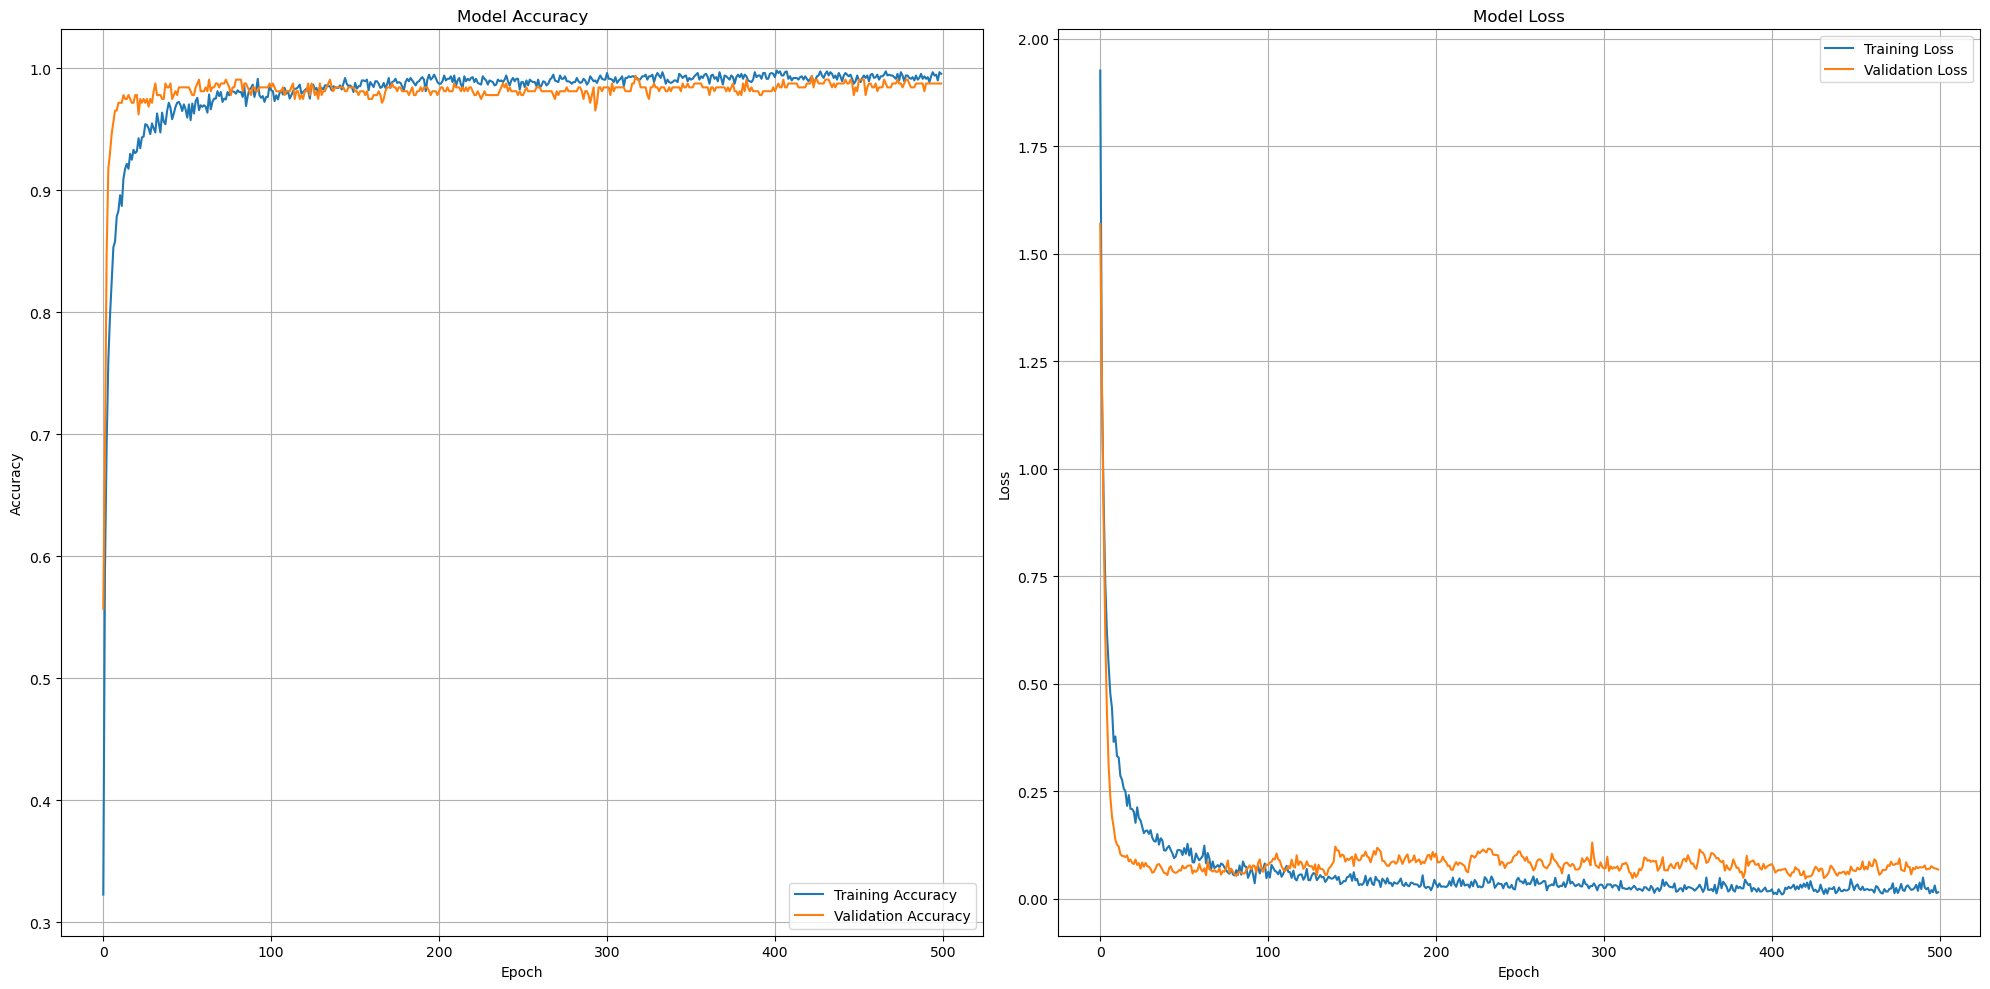

=== TRAINING SUMMARY ===
Final Training Accuracy: 0.9953
Final Validation Accuracy: 0.9873
Final Training Loss: 0.0150
Final Validation Loss: 0.0677
Total Epochs Completed: 500

Best Validation Accuracy: 0.9937 (Epoch 318)
Best Validation Loss: 0.0464 (Epoch 421)


In [35]:

def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Training summary
print("=== TRAINING SUMMARY ===")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Total Epochs Completed: {len(history.history['accuracy'])}")

# Best validation metrics
best_val_acc_idx = np.argmax(history.history['val_accuracy'])
print(f"\nBest Validation Accuracy: {max(history.history['val_accuracy']):.4f} (Epoch {best_val_acc_idx + 1})")

best_val_loss_idx = np.argmin(history.history['val_loss'])
print(f"Best Validation Loss: {min(history.history['val_loss']):.4f} (Epoch {best_val_loss_idx + 1})")

**Model Evaluation**

In [36]:
print("=== MODEL EVALUATION - ALL MODELS ===\n")

# Get MLP predictions on test set
print("Getting MLP predictions on test set...")
y_test_pred_mlp = np.argmax(NeuralNetwork.predict(test_dataset, verbose=0), axis=1)
y_test_proba_mlp = NeuralNetwork.predict(test_dataset, verbose=0)
print("✅ MLP predictions completed\n")

# Calculate accuracies for all models
acc_lr = accuracy_score(y_test, y_test_pred_lr)
acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
acc_mlp = accuracy_score(y_test, y_test_pred_mlp)

print("=== TEST SET ACCURACY ===")
print(f"Logistic Regression: {acc_lr:.4f}")
print(f"XGBoost:             {acc_xgb:.4f}")
print(f"Neural Network:      {acc_mlp:.4f}")
print()

# Determine best model based on test accuracy
models_dict = {
    'LogisticRegression': {
        'accuracy': acc_lr,
        'predictions': y_test_pred_lr,
        'probabilities': y_test_proba_lr,
        'model': lr_model
    },
    'XGBoost': {
        'accuracy': acc_xgb,
        'predictions': y_test_pred_xgb,
        'probabilities': y_test_proba_xgb,
        'model': xgboost_model
    },
    'NeuralNetwork': {
        'accuracy': acc_mlp,
        'predictions': y_test_pred_mlp,
        'probabilities': y_test_proba_mlp,
        'model': NeuralNetwork
    }
}

# Find best model
best_name = max(models_dict, key=lambda k: models_dict[k]['accuracy'])
best_model_info = models_dict[best_name]

print(f"🏆 Best model on test set: {best_name}")
print(f"   Test Accuracy: {best_model_info['accuracy']:.4f}\n")

# Extract best model info
y_pred_best = best_model_info['predictions']
y_proba_best = best_model_info['probabilities']
model_obj = best_model_info['model']

=== MODEL EVALUATION - ALL MODELS ===

Getting MLP predictions on test set...
✅ MLP predictions completed

=== TEST SET ACCURACY ===
Logistic Regression: 0.9653
XGBoost:             0.9779
Neural Network:      0.9653

🏆 Best model on test set: XGBoost
   Test Accuracy: 0.9779



In [37]:
print("=== DETAILED METRICS - ALL MODELS ON TEST SET ===\n")

# Calculate detailed metrics for each model
all_metrics = {}

for model_name, model_info in models_dict.items():
    y_pred = model_info['predictions']
    y_proba = model_info['probabilities']
    
    print(f"--- {model_name} ---")
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # ROC-AUC
    try:
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        roc_auc = roc_auc_score(y_test_bin, y_proba, average='weighted', multi_class='ovr')
        print(f"ROC-AUC:   {roc_auc:.4f}")
    except Exception as e:
        roc_auc = None
        print(f"ROC-AUC:   N/A")
    
    print()
    
    all_metrics[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc if roc_auc else 0
    }

=== DETAILED METRICS - ALL MODELS ON TEST SET ===

--- LogisticRegression ---
Accuracy:  0.9653
Precision: 0.9653
Recall:    0.9653
F1-Score:  0.9650
ROC-AUC:   0.9949

--- XGBoost ---
Accuracy:  0.9779
Precision: 0.9781
Recall:    0.9779
F1-Score:  0.9778
ROC-AUC:   0.9997

--- NeuralNetwork ---
Accuracy:  0.9653
Precision: 0.9658
Recall:    0.9653
F1-Score:  0.9654
ROC-AUC:   0.9982



=== METRICS COMPARISON TABLE ===

                    accuracy  precision  recall      f1  roc_auc
LogisticRegression    0.9653     0.9653  0.9653  0.9650   0.9949
XGBoost               0.9779     0.9781  0.9779  0.9778   0.9997
NeuralNetwork         0.9653     0.9658  0.9653  0.9654   0.9982



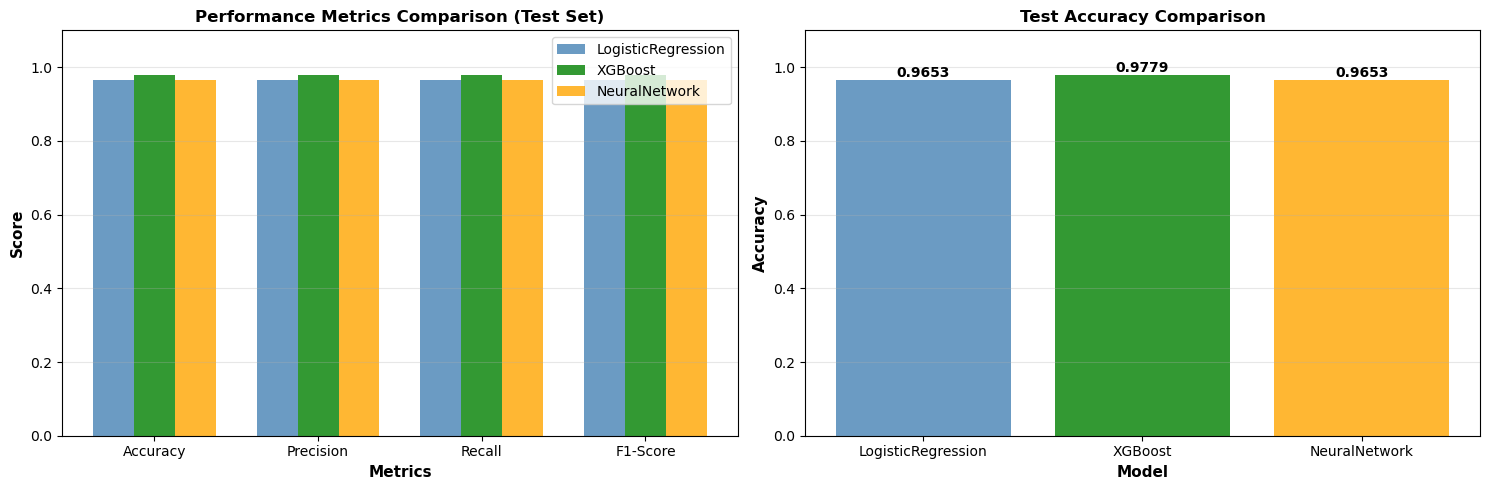

In [38]:
print("=== METRICS COMPARISON TABLE ===\n")

# Create comparison DataFrame
metrics_df = pd.DataFrame(all_metrics).T
metrics_df = metrics_df.round(4)
print(metrics_df)
print()

# Visualize metrics comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: All metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x_pos = np.arange(len(metrics_to_plot))
width = 0.25

for idx, (model_name, color) in enumerate(zip(
    ['LogisticRegression', 'XGBoost', 'NeuralNetwork'],
    ['steelblue', 'green', 'orange']
)):
    values = [all_metrics[model_name][m] for m in metrics_to_plot]
    axes[0].bar(x_pos + idx * width, values, width, label=model_name, alpha=0.8, color=color)

axes[0].set_xlabel('Metrics', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0].set_title('Performance Metrics Comparison (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

# Plot 2: Accuracy comparison
models = list(all_metrics.keys())
accuracies = [all_metrics[m]['accuracy'] for m in models]
colors = ['steelblue', 'green', 'orange']

bars = axes[1].bar(models, accuracies, color=colors, alpha=0.8)
axes[1].set_xlabel('Model', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.1])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


=== CONFUSION MATRICES - ALL MODELS ===



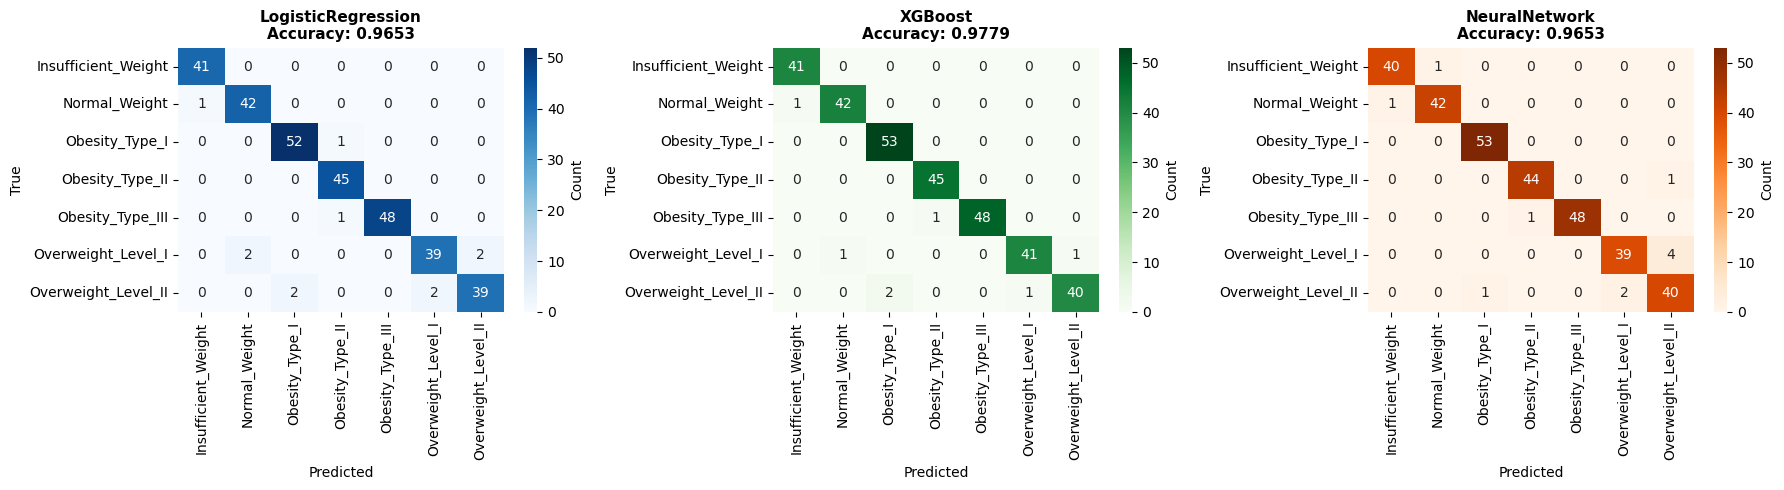

In [39]:
print("\n=== CONFUSION MATRICES - ALL MODELS ===\n")

# Create confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = list(target_encoder.classes_)

for idx, (model_name, ax) in enumerate(zip(
    ['LogisticRegression', 'XGBoost', 'NeuralNetwork'],
    axes
)):
    cm = confusion_matrix(y_test, models_dict[model_name]['predictions'])
    
    # Choose color map
    cmaps = ['Blues', 'Greens', 'Oranges']
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap=cmaps[idx],
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
        cbar_kws={'label': 'Count'}
    )
    
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.set_title(f'{model_name}\nAccuracy: {models_dict[model_name]["accuracy"]:.4f}', 
                 fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [40]:
print("=== CLASSIFICATION REPORTS - ALL MODELS ===\n")

for model_name in ['LogisticRegression', 'XGBoost', 'NeuralNetwork']:
    print(f"--- {model_name} ---")
    print(classification_report(
        y_test, 
        models_dict[model_name]['predictions'],
        target_names=labels,
        digits=4,
        zero_division=0
    ))
    print()

=== CLASSIFICATION REPORTS - ALL MODELS ===

--- LogisticRegression ---
                     precision    recall  f1-score   support

Insufficient_Weight     0.9762    1.0000    0.9880        41
      Normal_Weight     0.9545    0.9767    0.9655        43
     Obesity_Type_I     0.9630    0.9811    0.9720        53
    Obesity_Type_II     0.9574    1.0000    0.9783        45
   Obesity_Type_III     1.0000    0.9796    0.9897        49
 Overweight_Level_I     0.9512    0.9070    0.9286        43
Overweight_Level_II     0.9512    0.9070    0.9286        43

           accuracy                         0.9653       317
          macro avg     0.9648    0.9645    0.9644       317
       weighted avg     0.9653    0.9653    0.9650       317


--- XGBoost ---
                     precision    recall  f1-score   support

Insufficient_Weight     0.9762    1.0000    0.9880        41
      Normal_Weight     0.9767    0.9767    0.9767        43
     Obesity_Type_I     0.9636    1.0000    0.9815   

=== BEST MODEL ANALYSIS ===



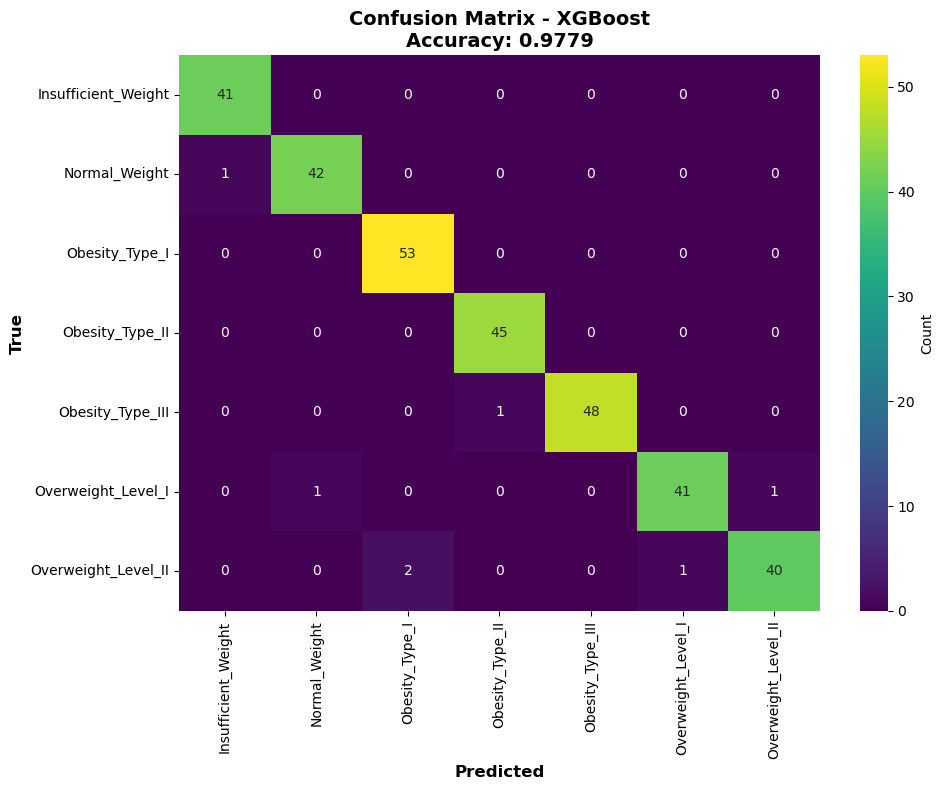


Classification Report - XGBoost:
                     precision    recall  f1-score   support

Insufficient_Weight     0.9762    1.0000    0.9880        41
      Normal_Weight     0.9767    0.9767    0.9767        43
     Obesity_Type_I     0.9636    1.0000    0.9815        53
    Obesity_Type_II     0.9783    1.0000    0.9890        45
   Obesity_Type_III     1.0000    0.9796    0.9897        49
 Overweight_Level_I     0.9762    0.9535    0.9647        43
Overweight_Level_II     0.9756    0.9302    0.9524        43

           accuracy                         0.9779       317
          macro avg     0.9781    0.9772    0.9774       317
       weighted avg     0.9781    0.9779    0.9778       317



<Figure size 640x480 with 0 Axes>

In [41]:
print("=== BEST MODEL ANALYSIS ===\n")

# Confusion Matrix for best model
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='viridis',
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - {best_name}\nAccuracy: {best_model_info["accuracy"]:.4f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig(f'confusion_matrix_{best_name}.png')

print(f"\nClassification Report - {best_name}:")
print(classification_report(y_test, y_pred_best, target_names=labels, digits=4, zero_division=0))


=== ROC CURVES - BEST MODEL ===



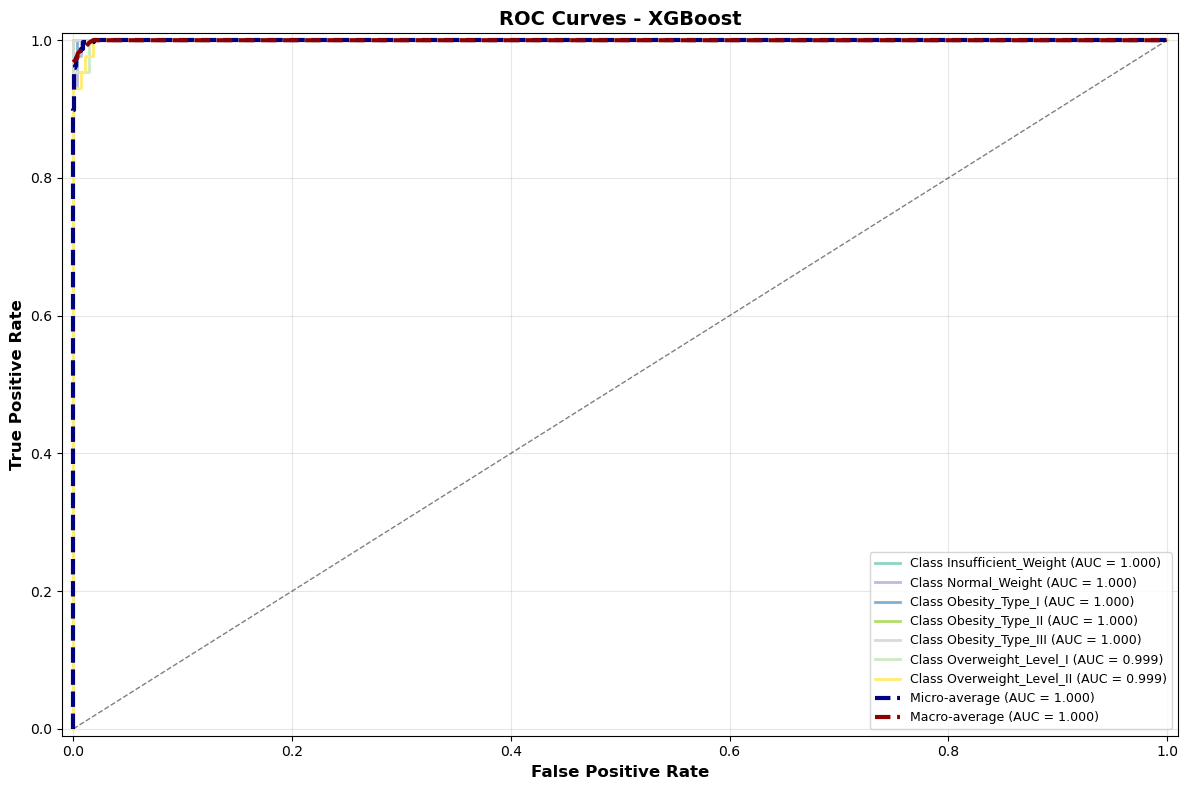

In [42]:
print("\n=== ROC CURVES - BEST MODEL ===\n")

# ROC Curves for best model (multiclass)
n_classes = y_proba_best.shape[1]
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

plt.figure(figsize=(12, 8))

# Per-class ROC curves
colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, 
             label=f'Class {labels[i]} (AUC = {roc_auc:.3f})')

# Micro-average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_proba_best.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='navy', linestyle='--', lw=3,
         label=f'Micro-average (AUC = {roc_auc_micro:.3f})')

# Macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_proba_best[:, i])[0] 
                                     for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_best[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)
plt.plot(all_fpr, mean_tpr, color='darkred', linestyle='--', lw=3,
         label=f'Macro-average (AUC = {roc_auc_macro:.3f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title(f'ROC Curves - {best_name}', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== FEATURE IMPORTANCE / COEFFICIENTS ===



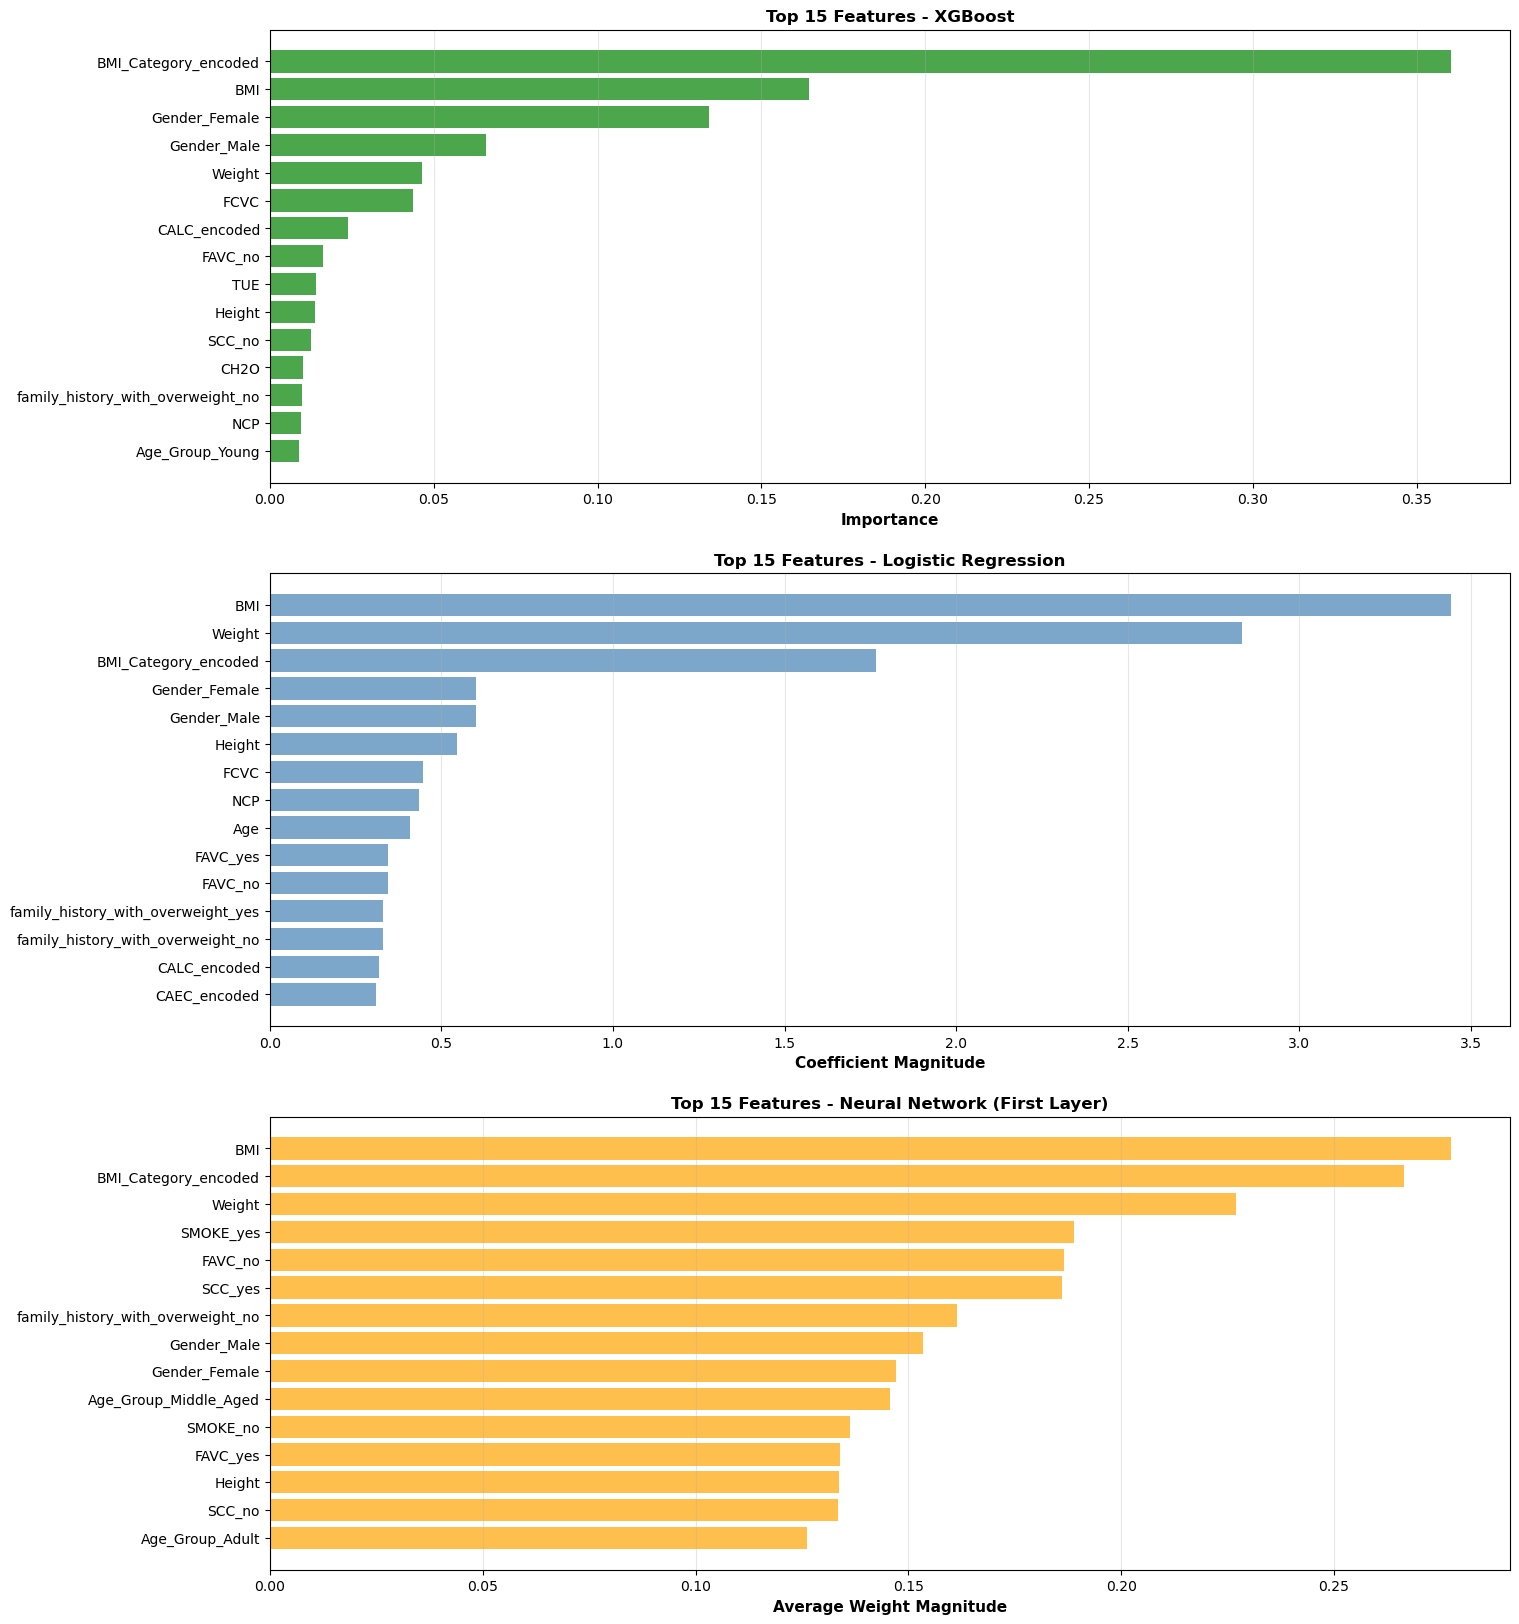

In [43]:
print("\n=== FEATURE IMPORTANCE / COEFFICIENTS ===\n")

feature_names = X_test.columns if hasattr(X_test, "columns") else [f"f{i}" for i in range(X_test.shape[1])]

fig, axes = plt.subplots(3, 1, figsize=(16, 20))

# Plot 1: XGBoost Feature Importance
if hasattr(xgboost_model, "feature_importances_"):
    importances = xgboost_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    top_n = min(15, len(importances))
    
    top_features = np.array(feature_names)[sorted_idx][:top_n]
    top_importances = importances[sorted_idx][:top_n]
    
    axes[0].barh(range(len(top_features)), top_importances, color='green', alpha=0.7)
    axes[0].set_yticks(range(len(top_features)))
    axes[0].set_yticklabels(top_features)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Importance', fontsize=11, fontweight='bold')
    axes[0].set_title('Top 15 Features - XGBoost', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Logistic Regression Coefficients
if hasattr(lr_model, "coef_"):
    coefs = np.abs(lr_model.coef_).mean(axis=0)
    sorted_idx = np.argsort(coefs)[::-1]
    top_n = min(15, len(coefs))
    
    top_features = np.array(feature_names)[sorted_idx][:top_n]
    top_coefs = coefs[sorted_idx][:top_n]
    
    axes[1].barh(range(len(top_features)), top_coefs, color='steelblue', alpha=0.7)
    axes[1].set_yticks(range(len(top_features)))
    axes[1].set_yticklabels(top_features)
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Coefficient Magnitude', fontsize=11, fontweight='bold')
    axes[1].set_title('Top 15 Features - Logistic Regression', fontsize=12, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
if hasattr(NeuralNetwork, "layers"):
    # Plot 3: Neural Network Weights (first layer)
    weights, biases = history.model.layers[0].get_weights()
    weight_magnitudes = np.abs(weights).mean(axis=1)
    sorted_idx = np.argsort(weight_magnitudes)[::-1]
    top_n = min(15, len(weight_magnitudes))
    
    top_features = np.array(feature_names)[sorted_idx][:top_n]
    top_weights = weight_magnitudes[sorted_idx][:top_n]
    
    axes[2].barh(range(len(top_features)), top_weights, color='orange', alpha=0.7)
    axes[2].set_yticks(range(len(top_features)))
    axes[2].set_yticklabels(top_features)
    axes[2].invert_yaxis()
    axes[2].set_xlabel('Average Weight Magnitude', fontsize=11, fontweight='bold')
    axes[2].set_title('Top 15 Features - Neural Network (First Layer)', fontsize=12, fontweight='bold')
    axes[2].grid(axis='x', alpha=0.3)
    
#plt.tight_layout()
plt.show()
    


In [44]:
print("\n=== MISCLASSIFICATION ANALYSIS ===\n")

# Best model confusion matrix analysis
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_no_diag = cm_df.copy()
np.fill_diagonal(cm_no_diag.values, 0)

# Top confused pairs
confused = cm_no_diag.stack().sort_values(ascending=False)
print(f"Top 10 Misclassified Pairs ({best_name}):")
print(confused.head(10))
print()

# Per-class error analysis
print("Per-Class Error Analysis:")
for i, label in enumerate(labels):
    total = cm[i].sum()
    correct = cm[i, i]
    errors = total - correct
    error_rate = (errors / total * 100) if total > 0 else 0
    
    print(f"{label}:")
    print(f"  Total samples: {total}")
    print(f"  Correct: {correct} ({correct/total*100:.1f}%)")
    print(f"  Errors: {errors} ({error_rate:.1f}%)")
    
    if errors > 0:
        # Show top misclassifications for this class
        misclass = [(labels[j], cm[i, j]) for j in range(len(labels)) if i != j and cm[i, j] > 0]
        misclass.sort(key=lambda x: x[1], reverse=True)
        if misclass:
            print(f"  Most confused with: {misclass[0][0]} ({misclass[0][1]} samples)")
    print()


=== MISCLASSIFICATION ANALYSIS ===

Top 10 Misclassified Pairs (XGBoost):
Overweight_Level_II  Obesity_Type_I         2
                     Overweight_Level_I     1
Normal_Weight        Insufficient_Weight    1
Overweight_Level_I   Overweight_Level_II    1
Obesity_Type_III     Obesity_Type_II        1
Overweight_Level_I   Normal_Weight          1
Insufficient_Weight  Insufficient_Weight    0
Overweight_Level_I   Insufficient_Weight    0
Obesity_Type_II      Overweight_Level_II    0
Obesity_Type_III     Insufficient_Weight    0
dtype: int64

Per-Class Error Analysis:
Insufficient_Weight:
  Total samples: 41
  Correct: 41 (100.0%)
  Errors: 0 (0.0%)

Normal_Weight:
  Total samples: 43
  Correct: 42 (97.7%)
  Errors: 1 (2.3%)
  Most confused with: Insufficient_Weight (1 samples)

Obesity_Type_I:
  Total samples: 53
  Correct: 53 (100.0%)
  Errors: 0 (0.0%)

Obesity_Type_II:
  Total samples: 45
  Correct: 45 (100.0%)
  Errors: 0 (0.0%)

Obesity_Type_III:
  Total samples: 49
  Correct: 48

In [45]:
print("=== FINAL RECOMMENDATION ===\n")

# Rank models
ranked_models = sorted(all_metrics.items(), key=lambda x: x[1]['accuracy'], reverse=True)

print("Model Ranking (by Test Accuracy):")
for rank, (model_name, metrics) in enumerate(ranked_models, 1):
    print(f"{rank}. {model_name}")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1-Score:  {metrics['f1']:.4f}")
    print()

print("🎯 RECOMMENDATION:")
print(f"   Best Model: {best_name}")
print(f"   Test Accuracy: {best_model_info['accuracy']:.4f}")
print()

# Model characteristics
print("Model Characteristics:")
print("\n  📊 Logistic Regression:")
print("     ✓ Fast training and inference")
print("     ✓ Highly interpretable coefficients")
print("     ✓ Good baseline model")
print("     ✗ Limited to linear decision boundaries")
print("     ✗ May underfit complex patterns")

print("\n  🌲 XGBoost:")
print("     ✓ Excellent for tabular data")
print("     ✓ Handles non-linear relationships")
print("     ✓ Built-in feature importance")
print("     ✓ Robust to outliers and missing data")
print("     ✗ Longer training time")
print("     ✗ More hyperparameters to tune")

print("\n  🧠 Neural Network (MLP):")
print("     ✓ Can learn complex patterns")
print("     ✓ Flexible architecture")
print("     ✓ Good with large datasets")
print("     ✗ Requires more data")
print("     ✗ Less interpretable")
print("     ✗ Prone to overfitting without regularization")

# Performance difference
if len(ranked_models) > 1:
    best_acc = ranked_models[0][1]['accuracy']
    second_acc = ranked_models[1][1]['accuracy']
    diff = (best_acc - second_acc) * 100
    
    print(f"\n  Performance Gap:")
    print(f"  {ranked_models[0][0]} outperforms {ranked_models[1][0]} by {diff:.2f}%")

=== FINAL RECOMMENDATION ===

Model Ranking (by Test Accuracy):
1. XGBoost
   Accuracy:  0.9779
   Precision: 0.9781
   Recall:    0.9779
   F1-Score:  0.9778

2. LogisticRegression
   Accuracy:  0.9653
   Precision: 0.9653
   Recall:    0.9653
   F1-Score:  0.9650

3. NeuralNetwork
   Accuracy:  0.9653
   Precision: 0.9658
   Recall:    0.9653
   F1-Score:  0.9654

🎯 RECOMMENDATION:
   Best Model: XGBoost
   Test Accuracy: 0.9779

Model Characteristics:

  📊 Logistic Regression:
     ✓ Fast training and inference
     ✓ Highly interpretable coefficients
     ✓ Good baseline model
     ✗ Limited to linear decision boundaries
     ✗ May underfit complex patterns

  🌲 XGBoost:
     ✓ Excellent for tabular data
     ✓ Handles non-linear relationships
     ✓ Built-in feature importance
     ✓ Robust to outliers and missing data
     ✗ Longer training time
     ✗ More hyperparameters to tune

  🧠 Neural Network (MLP):
     ✓ Can learn complex patterns
     ✓ Flexible architecture
     ✓ Goo